# DESeq - raw LFC
# Phase 2 vs. Phase 2

focusing on pairwise comparisons of oysters that experienced both phase 1 and phase 2

## 0. load libraries

In [18]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano) # for volcano plots
library(vegan) # for permanova
library(pheatmap)
library(RColorBrewer)
library(vsn) # Variance stabilization and calibration for microarray data

## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts.df <- counts %>%
select(-Gene_ID, -Length)

head(counts.df)

B1_B1_O01 B1_Nu_O03 B1_W5_O50 B2_B5_O51 B2_C4_O40 B2_Nu_O12
LOC111116054   2         1         6        10         9        16      
LOC111126949 885       652       477       654       586       523      
LOC111110729  64       209        93        63       100       177      
LOC111112434  11         7         2         0         2         2      
LOC111120752 360       586       336       426       351       417      
LOC111128944   0         0         0         0         0         0      
             B3_B4_O41 B3_C3_O30 B3_C6_O66 B3_H4_O41 ⋯ W5_C4_G45 W5_H4_G46
LOC111116054   0        10        22         9       ⋯   9         2      
LOC111126949 392       357       496       540       ⋯ 407       740      
LOC111110729  76        98       235       181       ⋯  70       149      
LOC111112434  12        15        10        36       ⋯  11         6      
LOC111120752 236       278       761       373       ⋯ 359       345      
LOC111128944   0         0         0         0       ⋯   0         0      
             W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_Nu_G41 W6_Nu_G45
LOC111116054   8         5         2        19         1         2      
LOC111126949 707       406       418       424       492       330      
LOC111110729 121       115       126       108       118       115      
LOC111112434   4         0         2        16        22         0      
LOC111120752 438       278       287       416       621       251      
LOC111128944   0         0         0         0         0         1      
             W6_W3_G36 W6_W4_G48
LOC111116054   1         0      
LOC111126949 281       599      
LOC111110729 127       213      
LOC111112434   8         0      
LOC111120752 333       430      
LOC111128944   0         0

In [4]:
# number of genes with 0 counts for all samples
sum(rowSums(counts.df) == 0) # 3372 genes

# pre-filter those rows
counts.filtered <- counts.df[!rowSums(counts.df) == 0,]

# double check this worked
dim(counts.df) # 38838 total genes
dim(counts.filtered) # 35466 genes with at least 1 read

[1] 3372

[1] 38838   120

[1] 35466   120

### meta data
the meta data csv was already generated in [deseq_p1.v.p1](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb), so just reading in here

In [5]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)
dim(meta)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 warm             warm        normoxic  5             
B2_B5_O51 both             warm        hypoxic   5             
B2_C4_O40 control          ambient     normoxic  4             
B3_B4_O41 both             warm        hypoxic   4             
B3_C3_O30 control          ambient     normoxic  3

[1] 96  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [6]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
W6_W3_G36 warm             warm        normoxic  6             
W6_W4_G48 warm             warm        normoxic  6             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
W6_W3_G36 warm             warm        normoxic  3              warm warm     
W6_W4_G48 warm             warm        normoxic  4              warm warm

In [7]:
# setting the same order for counts matrix and meta data
counts.filtered <- counts.filtered[,rownames(meta)]
all(rownames(meta) == colnames(counts.filtered))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

removing two outlier samples (see [deseq_p2.v.p2.ipynb](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase2_v_phase2/deseq_p2.v.p2.ipynb)

In [8]:
# remove outliers from filtered counts matrix
counts_noOutliers <- counts.filtered %>%
select(-c(B5_C1_O09, H2_H5_B51))

# remove from meta 
meta_noOutliers <- meta[rownames(meta) %in% colnames(counts_noOutliers),]

# check dimensions - should have same number of samples (94)
dim(meta_noOutliers)
dim(counts_noOutliers)

# check samples are in the same order
all(rownames(meta_noOutliers) == colnames(counts_noOutliers))

[1] 94  9

[1] 35466    94

[1] TRUE

In [9]:
# creating DESeq2 object
dds.noOutliers <- DESeqDataSetFromMatrix(countData = counts_noOutliers,
                              colData = meta_noOutliers,
                              design = ~ complete_trtmt)
dds.noOutliers

# running DESeq
dds.noOutliers <- DESeq(dds.noOutliers)

# list coefficients
resultsNames(dds.noOutliers)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 35466 94 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.warm_vs_both.both"      
 [5] "complete_trtmt_control.both_vs_both.both"   
 [6] "complete_trtmt_control.control_vs_both.both"
 [7] "complete_trtmt_control.hypoxic_vs_both.both"
 [8] "complete_trtmt_control.warm_vs_both.both"   
 [9] "complete_trtmt_hypoxic.both_vs_both.both"   
[10] "complete_trtmt_hypoxic.control_vs_both.both"
[11] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[12] "complete_trtmt_hypoxic.warm_vs_both.both"   
[13] "complete_trtmt_warm.both_vs_both.both"      
[14] "complete_trtmt_warm.control_vs_both.both"   
[15] "complete_trtmt_warm.hypoxic_vs_both.both"   
[16] "complete_trtmt_warm.warm_vs_both.both"

In [10]:
dds <- dds.noOutliers

### variance stabilizing transformation
see [DESeq manual - data transformations and visualizations](https://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#data-transformations-and-visualization) section for info on this

vst stabilizes the variance across the range of counts - variance across samples becomes roughly consistent

In [23]:
vsd <- vst(dds, blind = TRUE) # DESeq "forgets" the design/groups, applies vst evenly across samples
head(vsd)

class: DESeqTransform 
dim: 6 94 
metadata(1): version
assays(1): ''
rownames(6): LOC111116054 LOC111126949 ... LOC111120752 LOC111128944
rowData names(78): baseMean baseVar ... maxCooks dispFit
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(10): Phase1_treatment Phase1_temp ... complete_trtmt
  sizeFactor

In [24]:
head(assay(vsd), 10)

B1_B1_O01 B1_W5_O50 B2_B5_O51 B2_C4_O40 B3_B4_O41 B3_C3_O30
LOC111116054  7.692872 7.805746  7.871959  7.843091  7.548551  7.909124 
LOC111126949 10.197580 9.653169  9.900281  9.718856  9.612738  9.545333 
LOC111110729  8.354765 8.542687  8.351593  8.513945  8.518601  8.653091 
LOC111112434  7.886383 7.697174  7.548551  7.687586  7.940109  7.989592 
LOC111120752  9.363550 9.355360  9.509373  9.284512  9.198871  9.337765 
LOC111128944  7.548551 7.548551  7.548551  7.548551  7.548551  7.548551 
LOC111128953  7.548551 7.548551  7.548551  7.548551  7.548551  7.710140 
LOC111105691  7.692872 7.845404  8.595408  8.101515  8.014009  8.149132 
LOC111133554  7.548551 7.548551  7.548551  7.843091  7.548551  7.828140 
LOC111125466  7.650623 7.548551  7.651014  7.548551  7.661902  7.926626 
             B3_C6_O66 B3_H4_O41 B3_W1_O06 B3_W4_O41 ⋯ W4_W5_G56 W5_B2_G21
LOC111116054 7.947895  7.869635  7.840134  7.758281  ⋯ 7.767900  7.713596 
LOC111126949 9.334530  9.803992  9.906070  9.592360  ⋯ 9.078093  9.779869 
LOC111110729 8.816678  8.937210  8.568640  8.590933  ⋯ 8.714150  8.368627 
LOC111112434 7.818256  8.186828  7.658920  7.879728  ⋯ 7.817069  7.548551 
LOC111120752 9.699834  9.473806  8.989457  9.167603  ⋯ 9.549481  9.234610 
LOC111128944 7.548551  7.548551  7.548551  7.548551  ⋯ 7.548551  7.548551 
LOC111128953 7.548551  7.548551  7.739622  7.548551  ⋯ 7.548551  7.548551 
LOC111105691 7.757585  8.212449  7.704598  7.805305  ⋯ 7.703729  7.713596 
LOC111133554 7.633951  7.548551  7.548551  7.548551  ⋯ 7.658304  7.683334 
LOC111125466 7.774301  7.548551  7.548551  7.548551  ⋯ 7.548551  7.548551 
             W5_C4_G45 W5_H4_G46 W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71
LOC111116054 7.900466   7.697844 7.834121  7.790482  7.708399  8.030152 
LOC111126949 9.712370  10.082883 9.950378  9.563392  9.665533  9.644851 
LOC111110729 8.514299   8.798284 8.635108  8.680883  8.780214  8.673395 
LOC111112434 7.937395   7.806904 7.750644  7.548551  7.708399  7.990820 
LOC111120752 9.599548   9.383933 9.510347  9.253648  9.345876  9.627837 
LOC111128944 7.548551   7.548551 7.548551  7.548551  7.548551  7.548551 
LOC111128953 7.548551   7.548551 7.548551  7.548551  7.548551  7.548551 
LOC111105691 7.859081   7.548551 8.010013  7.736037  7.905257  8.416445 
LOC111133554 7.811141   7.548551 7.548551  7.701669  7.825135  7.548551 
LOC111125466 7.548551   7.548551 7.548551  7.548551  7.744275  7.548551 
             W6_W3_G36 W6_W4_G48
LOC111116054 7.657898  7.548551 
LOC111126949 9.276775  9.929224 
LOC111110729 8.746416  9.064164 
LOC111112434 7.857315  7.548551 
LOC111120752 9.412129  9.619853 
LOC111128944 7.548551  7.548551 
LOC111128953 7.548551  7.548551 
LOC111105691 7.997691  7.548551 
LOC111133554 7.703154  7.548551 
LOC111125466 7.703154  7.548551

In [26]:
write.csv(assay(vsd), '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_vstCounts.csv')

## Pairwise comparisons

### 1. Effect of single exposure on GE after a period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

**CC vs. WC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 35, 0.099%
LFC < -1.00 (down) : 49, 0.14%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”
Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.
ℹ The deprecated feature was likely used in the EnhancedVolcano package.
  Please report the issue to the authors.”


Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.33057935    0.7505019 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.03262639    0.3590756 0    1      1    829.713451
3 LOC111110729 114.0070007  0.13818475    0.2487651 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.42625405    1.0587682 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.32137579    0.2874540 0    1      1    337.510556
6 LOC111128944   0.1088474  0.00000000    8.1608438 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

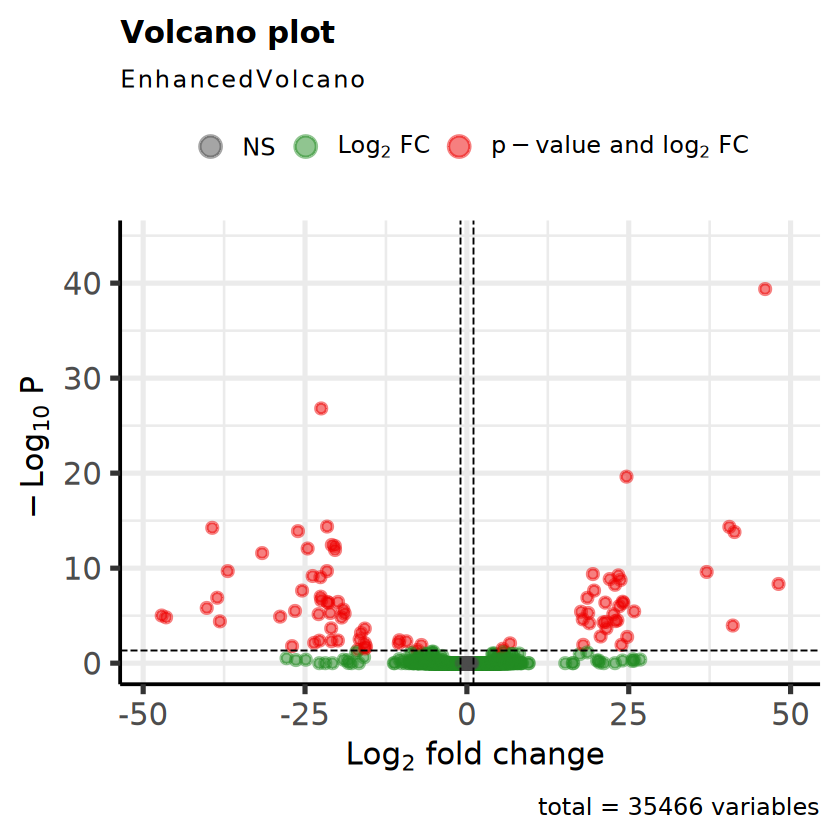

In [12]:
res.wc.cc <- results(dds, contrast = c('complete_trtmt', 'warm.control', 'control.control'), alpha = 0.05, lfcThreshold = 1)

summary(res.wc.cc)

EnhancedVolcano(res.wc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.cc <- merge(res.wc.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.cc)[1] <- 'Gene'

head(res.wc.cc)

In [14]:
write.csv(res.wc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wc_cc.csv', row.names = FALSE)

**CC vs. HC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 30, 0.085%
LFC < -1.00 (down) : 92, 0.26%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.1675376790  0.7565704 0    1      1      1.875059
2 LOC111126949 539.2853993  0.0005716879  0.3590027 0    1      1    829.713451
3 LOC111110729 114.0070007  0.0417591912  0.2489017 0    1      1     60.001877
4 LOC111112434   6.9517032  0.1251474516  1.0482040 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.2317762396  0.2873147 0    1      1    337.510556
6 LOC111128944   0.1088474  0.0000000000  8.1608438 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

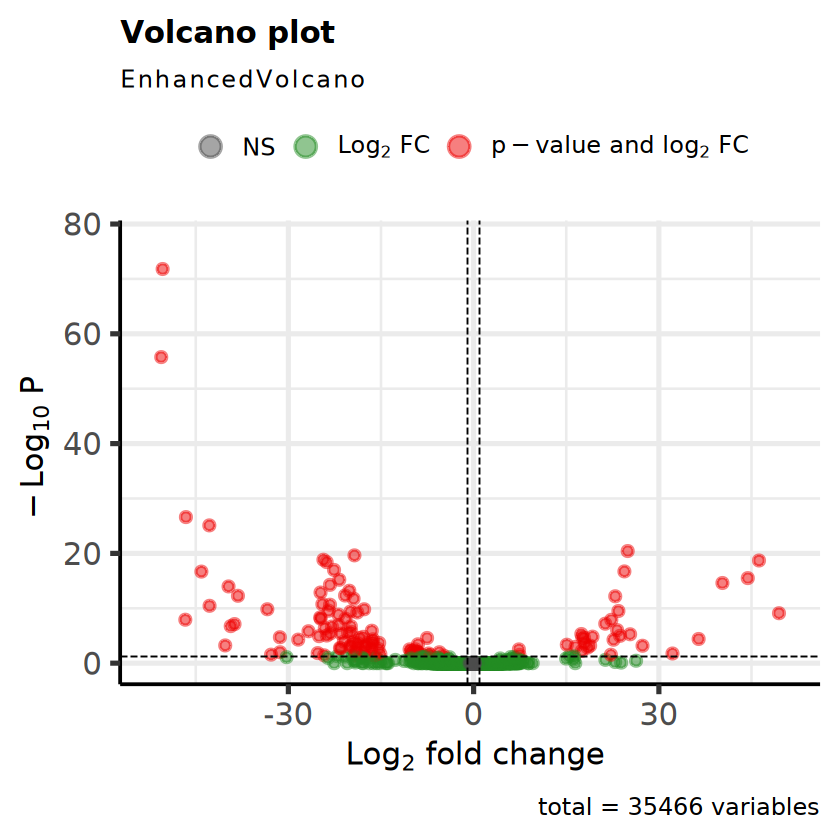

In [15]:
res.hc.cc <- results(dds, contrast= c('complete_trtmt', 'hypoxic.control', 'control.control'), # CC is the "control"
                      lfcThreshold = 1,
                    alpha = 0.05)

summary(res.hc.cc)

EnhancedVolcano(res.hc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hc.cc <- merge(res.hc.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hc.cc)[1] <- 'Gene'

head(res.hc.cc)

In [16]:
write.csv(res.hc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hc_cc.csv', row.names = FALSE)

**CC vs. BC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 31, 0.088%
LFC < -1.00 (down) : 138, 0.39%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.17769574    0.7932986 0    1      1      1.875059
2 LOC111126949 539.2853993  0.16712355    0.3763742 0    1      1    829.713451
3 LOC111110729 114.0070007  0.08635391    0.2606525 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.31013309    1.1064685 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.37383282    0.3014650 0    1      1    337.510556
6 LOC111128944   0.1088474  0.00000000    8.5591341 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

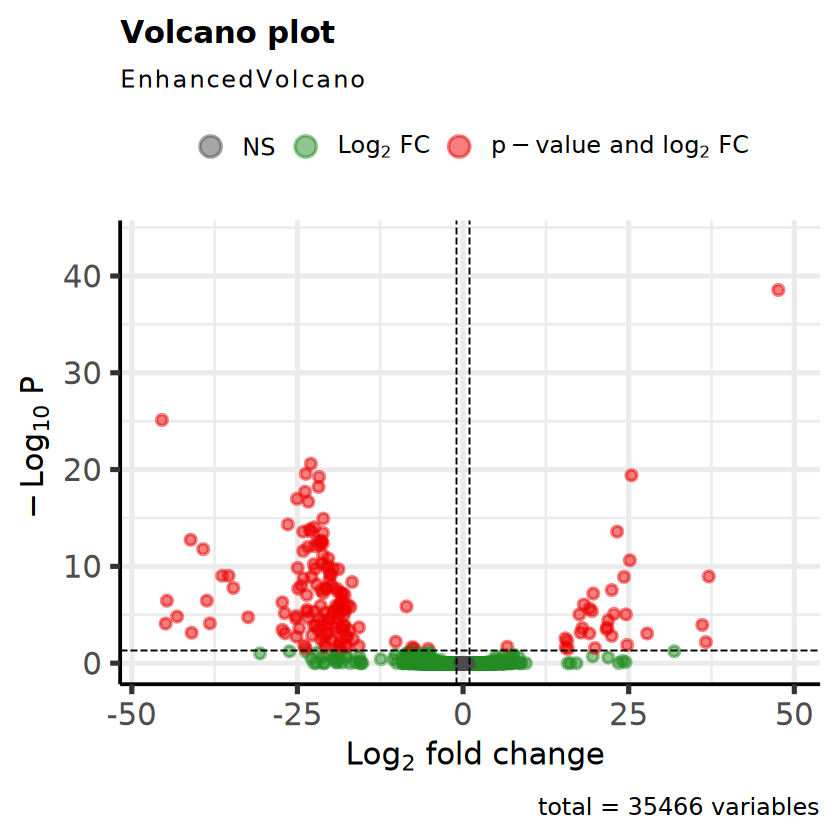

In [17]:
res.bc.cc <- results(dds, contrast= c('complete_trtmt', 'both.control', 'control.control'), # CC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bc.cc)

EnhancedVolcano(res.bc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.cc <- merge(res.bc.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.cc)[1] <- 'Gene'

head(res.bc.cc)

In [18]:
write.csv(res.bc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bc_cc.csv', row.names = FALSE)

### 2. Effect of single exposure experienced only later in life
- CC vs. CW
- CC vs. CH
- CC vs. CB

**CC vs. CW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 34, 0.096%
LFC < -1.00 (down) : 44, 0.12%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842 -0.2036021     0.7590510 0.00000000 1.0000000 1   
2 LOC111126949 539.2853993  0.3454646     0.3588453 0.00000000 1.0000000 1   
3 LOC111110729 114.0070007  0.5395364     0.2473930 0.00000000 1.0000000 1   
4 LOC111112434   6.9517032 -0.6700600     1.0654418 0.00000000 1.0000000 1   
5 LOC111120752 429.0263780 -0.4336789     0.2876068 0.00000000 1.0000000 1   
6 LOC111128944   0.1088474  1.1664359     8.1608438 0.02039445 0.9837287 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

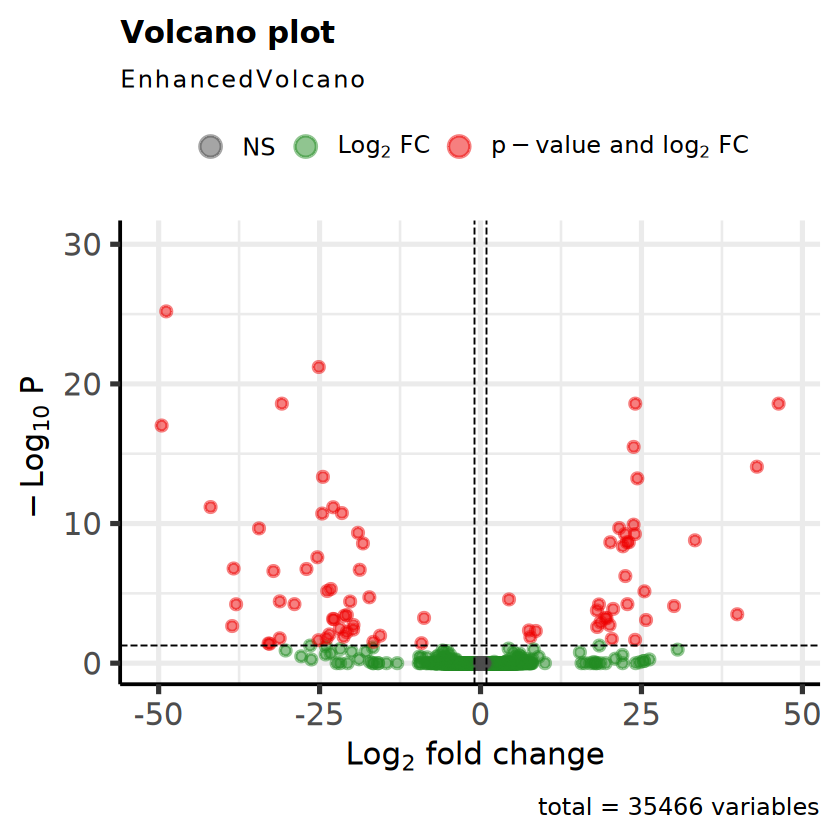

In [19]:
res.cw.cc <- results(dds, contrast= c('complete_trtmt', 'control.warm', 'control.control'), alpha = 0.05, lfcThreshold = 1)

summary(res.cw.cc)

EnhancedVolcano(res.cw.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.cc <- merge(res.cw.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.cc)[1] <- 'Gene'

head(res.cw.cc)

In [20]:
write.csv(res.cw.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cw_cc.csv', row.names = FALSE)

**CC vs. CH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 39, 0.11%
LFC < -1.00 (down) : 94, 0.27%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue   padj
1 LOC111116054   9.0629842 -0.98371654    0.7720278  0.00000000 1.000000 1   
2 LOC111126949 539.2853993  0.32443723    0.3587565  0.00000000 1.000000 1   
3 LOC111110729 114.0070007  0.08242201    0.2484221  0.00000000 1.000000 1   
4 LOC111112434   6.9517032 -1.02588884    1.0700600 -0.02419382 0.980698 1   
5 LOC111120752 429.0263780 -0.66558766    0.2876662  0.00000000 1.000000 1   
6 LOC111128944   0.1088474  0.97900704    8.1601844  0.00000000 1.000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

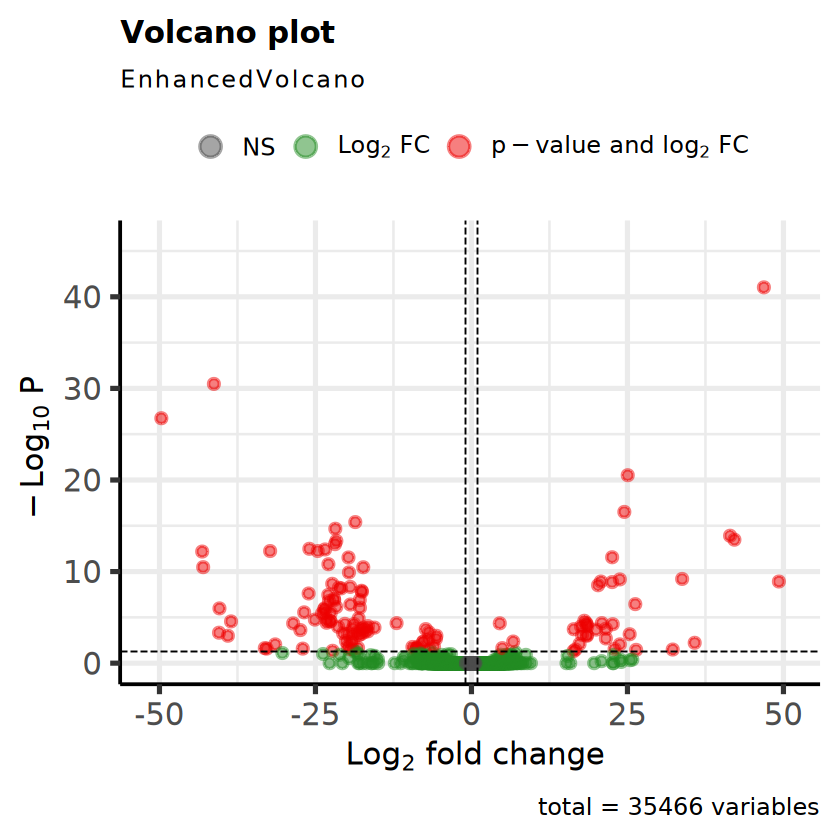

In [21]:
res.ch.cc <- results(dds, contrast= c('complete_trtmt', 'control.hypoxic', 'control.control'), # CC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.ch.cc)

EnhancedVolcano(res.ch.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ch.cc <- merge(res.ch.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ch.cc)[1] <- 'Gene'

head(res.ch.cc)

In [22]:
write.csv(res.ch.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/ch_cc.csv', row.names = FALSE)

**CC vs. CB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 37, 0.1%
LFC < -1.00 (down) : 86, 0.24%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.850312301   0.7453619 0    1      1      1.875059
2 LOC111126949 539.2853993  0.439928540   0.3587761 0    1      1    829.713451
3 LOC111110729 114.0070007  0.183781192   0.2486500 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.008001491   1.0514269 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.574426729   0.2877341 0    1      1    337.510556
6 LOC111128944   0.1088474  0.000000000   8.1608438 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

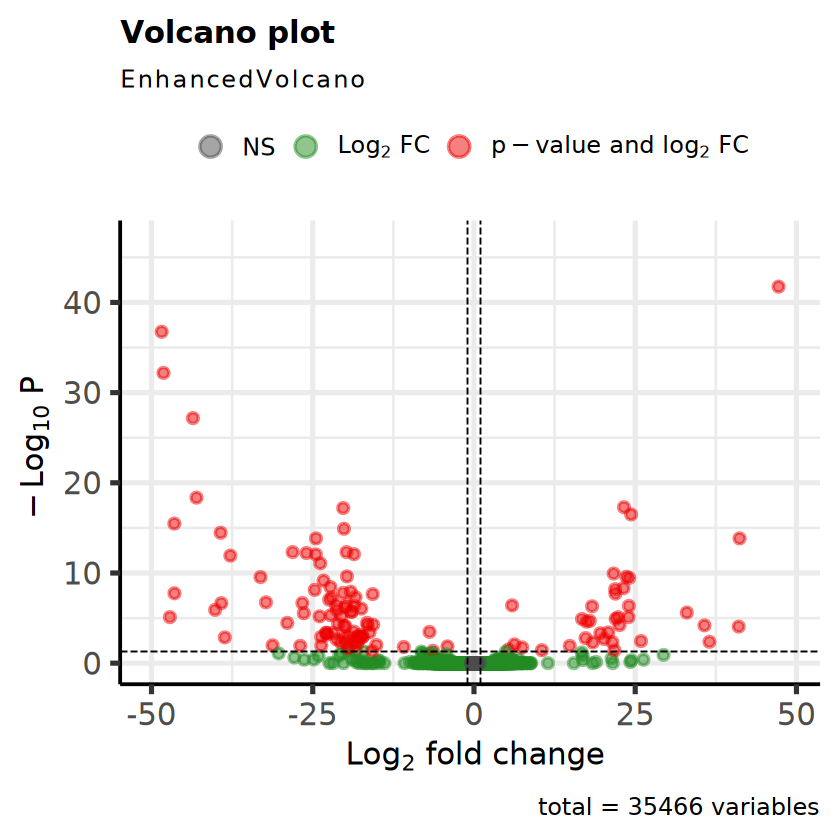

In [23]:
res.cb.cc <- results(dds, contrast= c('complete_trtmt', 'control.both', 'control.control'), # CC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cb.cc)

EnhancedVolcano(res.cb.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.cc <- merge(res.cb.cc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.cc)[1] <- 'Gene'

head(res.cb.cc)

In [24]:
write.csv(res.cb.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cb_cc.csv', row.names = FALSE)

### 3. Timing of Stress Exposure
How does GE change depending on when stress is experienced (when all oysters only experience stress once)?
- CH vs. HC
- CW vs. WC
- CB vs. BC

**CH vs. HC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 75, 0.21%
LFC < -1.00 (down) : 77, 0.22%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842 -0.81617886    0.7756948  0.0000000 1.0000000 1   
2 LOC111126949 539.2853993  0.32386554    0.3588161  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007  0.04066281    0.2486129  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032 -1.15103629    1.0695217 -0.1412185 0.8876973 1   
5 LOC111120752 429.0263780 -0.43381142    0.2879090  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474  0.89932574    8.1601844  0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

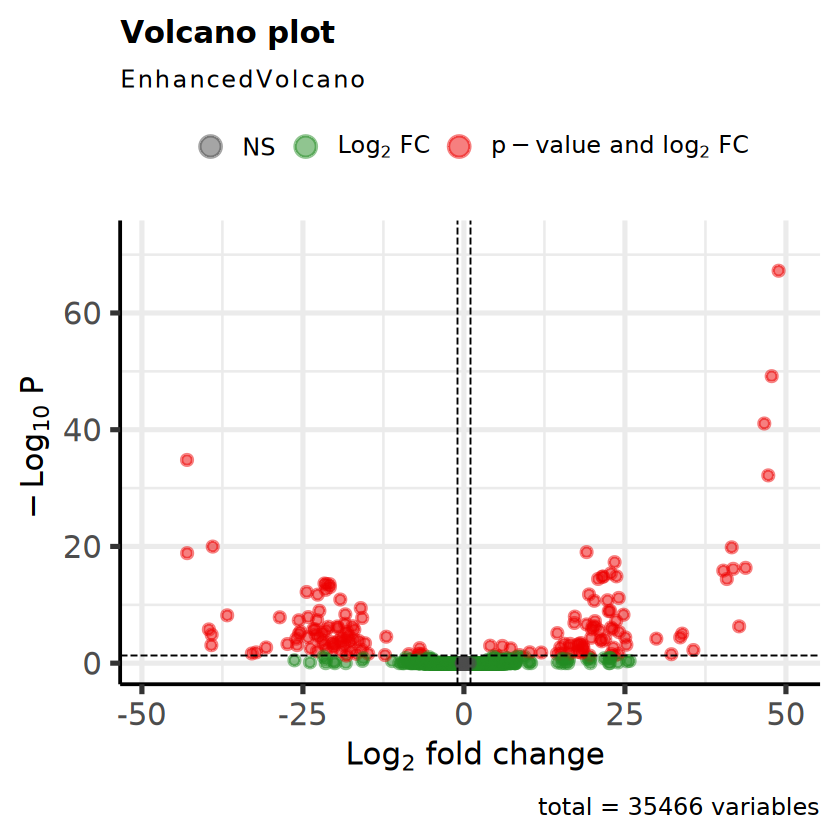

In [25]:
res.ch.hc <- results(dds, contrast= c('complete_trtmt', 'control.hypoxic', 'hypoxic.control'), # HC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.ch.hc)

EnhancedVolcano(res.ch.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ch.hc <- merge(res.ch.hc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ch.hc)[1] <- 'Gene'

head(res.ch.hc)

In [26]:
write.csv(res.ch.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/ch_hc.csv', row.names = FALSE)

**CW vs. WC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 47, 0.13%
LFC < -1.00 (down) : 48, 0.14%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    padj
1 LOC111116054   9.0629842 -0.5341815     0.7567618 0.000000000 1.0000000 1   
2 LOC111126949 539.2853993  0.3780910     0.3589779 0.000000000 1.0000000 1   
3 LOC111110729 114.0070007  0.4013516     0.2474473 0.000000000 1.0000000 1   
4 LOC111112434   6.9517032 -0.2438060     1.0753013 0.000000000 1.0000000 1   
5 LOC111120752 429.0263780 -0.1123031     0.2879887 0.000000000 1.0000000 1   
6 LOC111128944   0.1088474  1.0237769     8.1608438 0.002913532 0.9976753 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

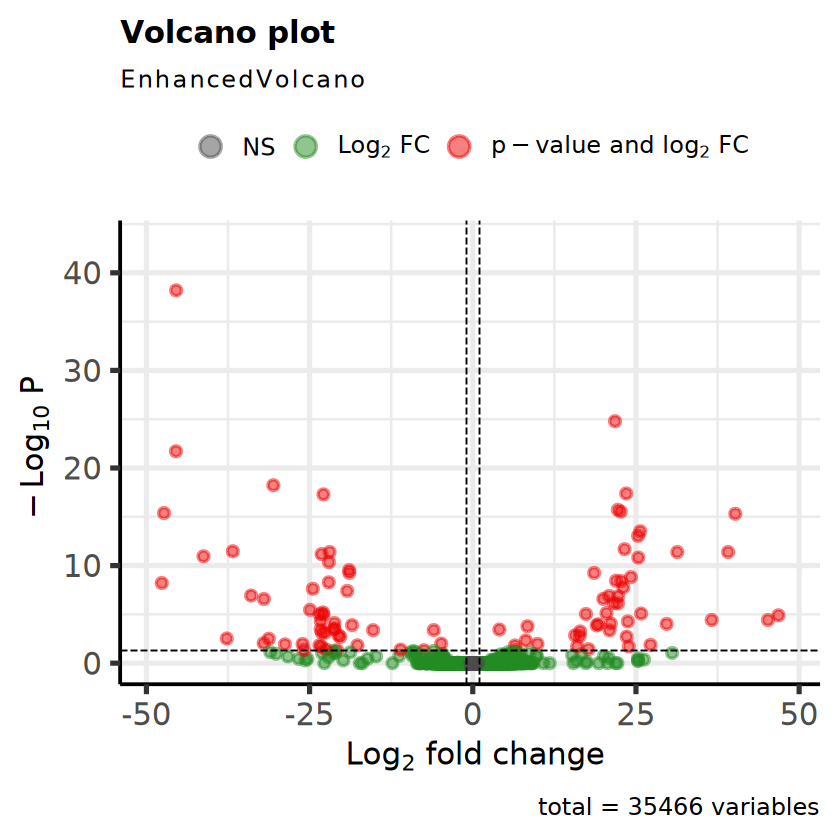

In [27]:
res.cw.wc <- results(dds, contrast= c('complete_trtmt', 'control.warm', 'warm.control'), # WC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cw.wc)

EnhancedVolcano(res.cw.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.wc <- merge(res.cw.wc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.wc)[1] <- 'Gene'

head(res.cw.wc)

In [28]:
write.csv(res.cw.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cw_wc.csv', row.names = FALSE)

**CB vs. BC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 135, 0.38%
LFC < -1.00 (down) : 75, 0.21%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842  1.02800804    0.7862340 0.03562304 0.9715829 1   
2 LOC111126949 539.2853993  0.27280499    0.3762149 0.00000000 1.0000000 1   
3 LOC111110729 114.0070007  0.09742729    0.2605943 0.00000000 1.0000000 1   
4 LOC111112434   6.9517032  0.30213160    1.1090030 0.00000000 1.0000000 1   
5 LOC111120752 429.0263780 -0.20059391    0.3020961 0.00000000 1.0000000 1   
6 LOC111128944   0.1088474  0.00000000    8.5591341 0.00000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

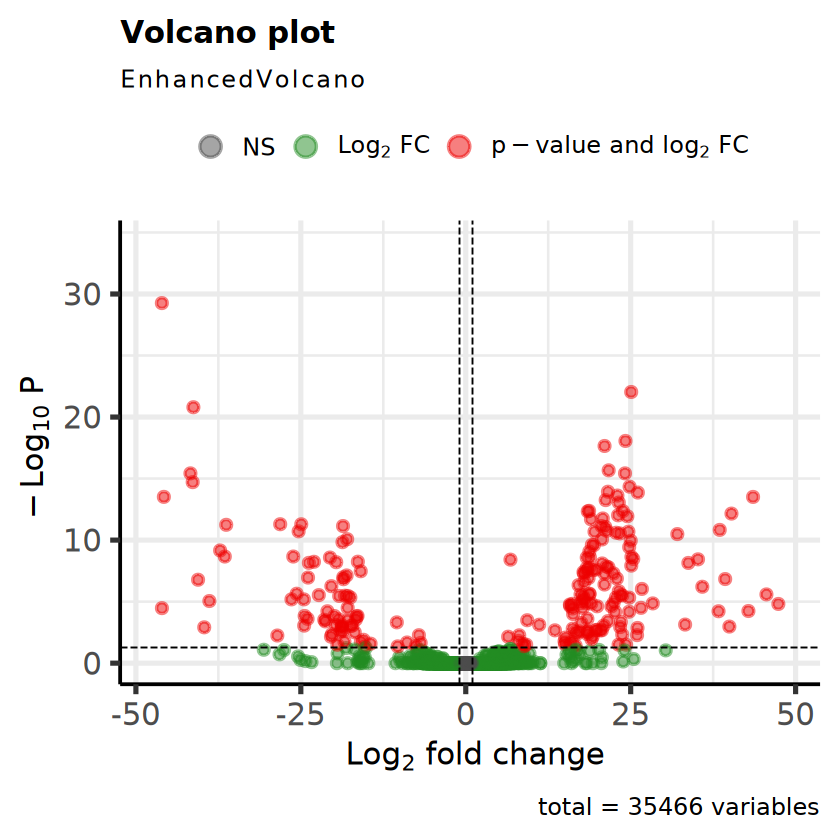

In [29]:
res.cb.bc <- results(dds, contrast= c('complete_trtmt', 'control.both', 'both.control'), # BC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cb.bc)

EnhancedVolcano(res.cb.bc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.bc <- merge(res.cb.bc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.bc)[1] <- 'Gene'

head(res.cb.bc)

In [30]:
write.csv(res.cb.bc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cb_bc.csv', row.names = FALSE)

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

**CC vs. WW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 45, 0.13%
LFC < -1.00 (down) : 50, 0.14%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842 -1.3280081     0.7844387 -0.4181438 0.6758420 1   
2 LOC111126949 539.2853993  0.0360299     0.3589705  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007  0.4982604     0.2471394  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032 -1.1886395     1.0770450 -0.1751454 0.8609653 1   
5 LOC111120752 429.0263780 -0.2845198     0.2873513  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474  2.0627372     8.1477666  0.1304330 0.8962239 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

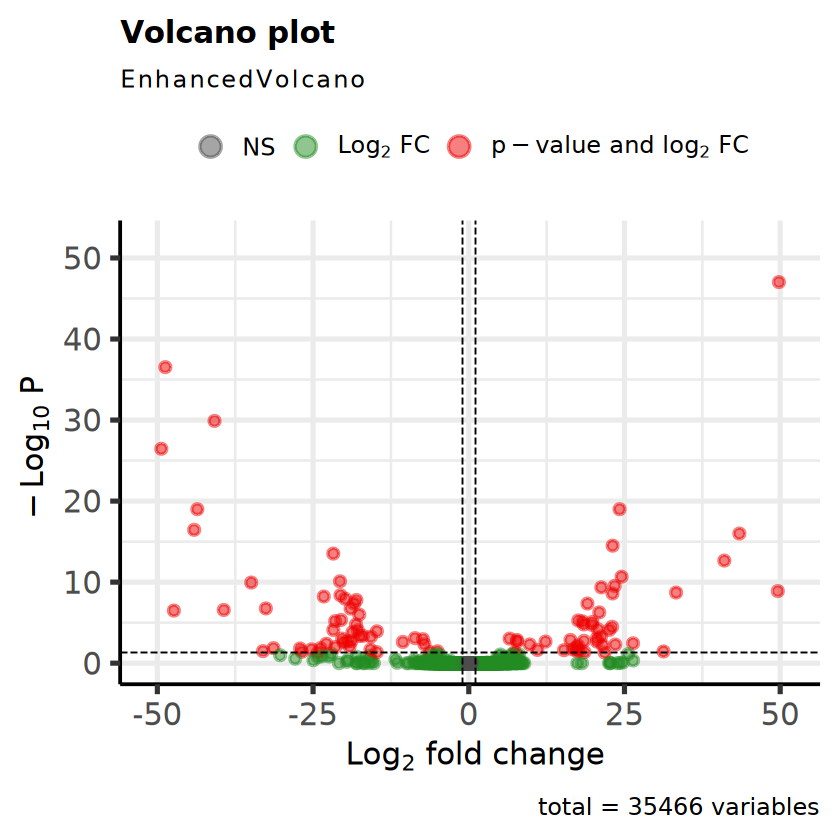

In [31]:
res.cc.ww <- results(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.control'), # CC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cc.ww)

EnhancedVolcano(res.cc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.ww <- merge(res.cc.ww, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.ww)[1] <- 'Gene'

head(res.cc.ww)

In [32]:
write.csv(res.cc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/ww_cc.csv', row.names = FALSE)

**CC vs. HH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 31, 0.088%
LFC < -1.00 (down) : 170, 0.48%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.6592917     0.8029928 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.5160196     0.3769626 0    1      1    829.713451
3 LOC111110729 114.0070007 -0.1187118     0.2615670 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.7138196     1.1153867 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.4570022     0.3015252 0    1      1    337.510556
6 LOC111128944   0.1088474  0.0000000     8.5591341 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

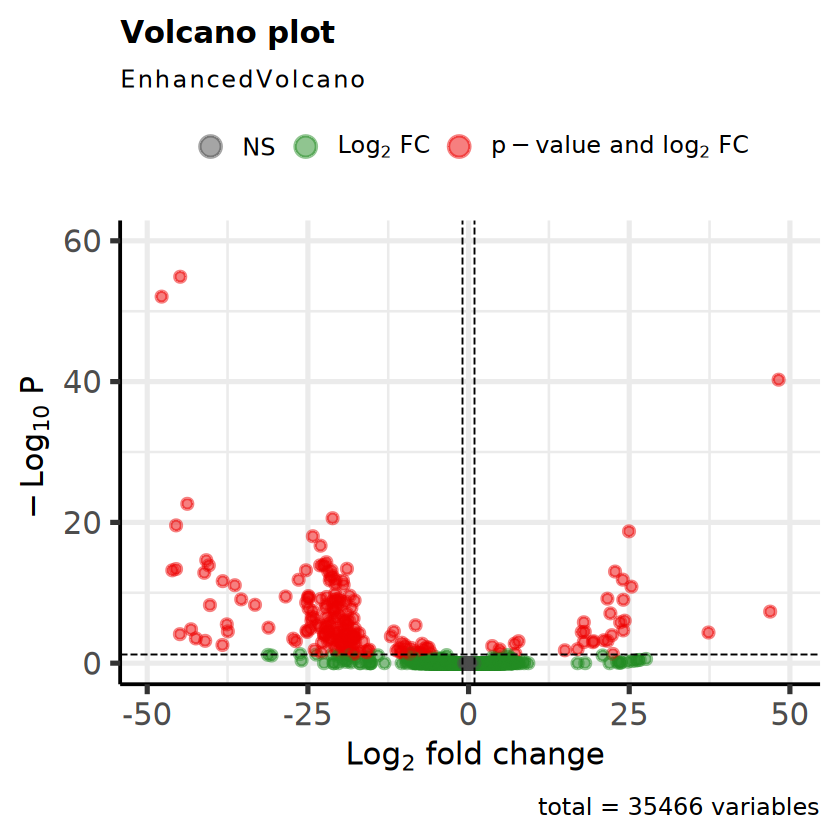

In [47]:
res.cc.hh <- results(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.control'), # CC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cc.hh)

EnhancedVolcano(res.cc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.hh <- merge(res.cc.hh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.hh)[1] <- 'Gene'

head(res.cc.hh)

In [34]:
write.csv(res.cc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hh_cc.csv', row.names = FALSE)

**CC vs. BB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 32, 0.09%
LFC < -1.00 (down) : 38, 0.11%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.9724579     0.7744508 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.4804654     0.3587225 0    1      1    829.713451
3 LOC111110729 114.0070007  0.2507333     0.2504561 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.4364549     1.0445850 0    1      1     10.312823
5 LOC111120752 429.0263780  0.6227132     0.2877221 0    1      1    337.510556
6 LOC111128944   0.1088474 -0.1110152     8.1585353 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

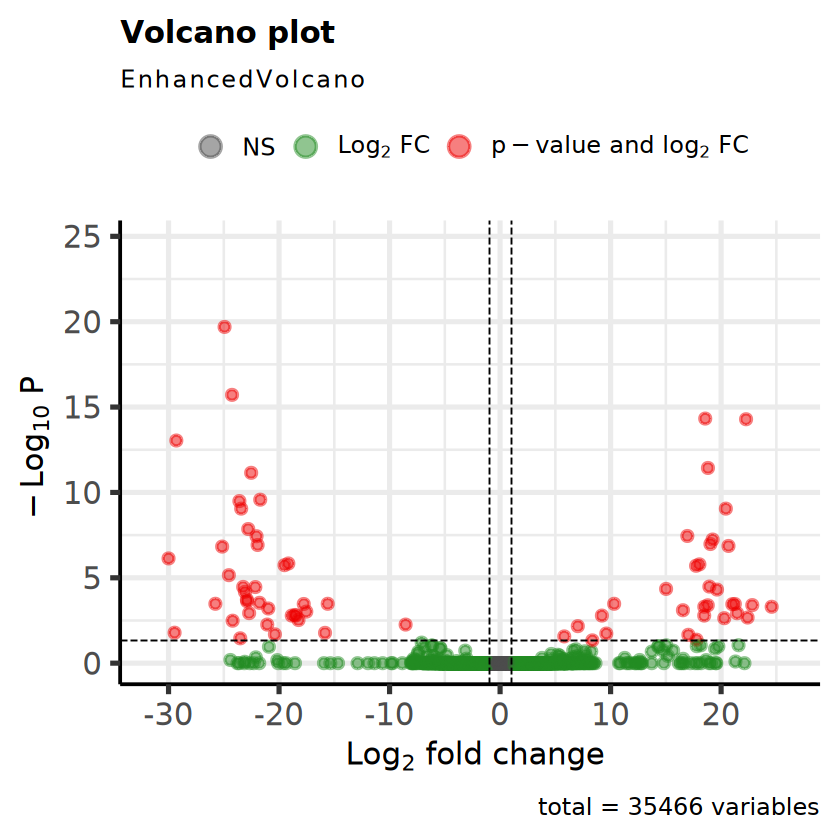

In [50]:
res.cc.bb <- results(dds, name ='complete_trtmt_control.control_vs_both.both', # BB is the 'control'
                             lfcThreshold = 1, alpha = 0.05)

summary(res.cc.bb)

EnhancedVolcano(res.cc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.bb <- merge(res.cc.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.bb)[1] <- 'Gene'

head(res.cc.bb)

switch LFC direction so CC is the baseline (deseq recognizes as bb as the baseline rn)

In [51]:
cc.bb.df <- as.data.frame(res.cc.bb) %>% # create df
mutate(log2FoldChange = log2FoldChange * -1) # multiple by -1 to make pos to neg and vice versa 

# validate
head(res.cc.bb)
head(cc.bb.df)

Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.9724579     0.7744508 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.4804654     0.3587225 0    1      1    829.713451
3 LOC111110729 114.0070007  0.2507333     0.2504561 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.4364549     1.0445850 0    1      1     10.312823
5 LOC111120752 429.0263780  0.6227132     0.2877221 0    1      1    337.510556
6 LOC111128944   0.1088474 -0.1110152     8.1585353 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.9724579     0.7744508 0    1      1      1.875059
2 LOC111126949 539.2853993  0.4804654     0.3587225 0    1      1    829.713451
3 LOC111110729 114.0070007 -0.2507333     0.2504561 0    1      1     60.001877
4 LOC111112434   6.9517032  0.4364549     1.0445850 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.6227132     0.2877221 0    1      1    337.510556
6 LOC111128944   0.1088474  0.1110152     8.1585353 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

In [52]:
write.csv(cc.bb.df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bb_cc.csv', row.names = FALSE)

### 5. Effect of initial exposure on response in later exposure
(also gets at the effect of priming to stress)

#### 5A. Matched stressors
Oyster is primed with a stress, and experiences the *same* stressor again
- HH vs. CH
- WW vs. CW
- BB vs. CB

**HH vs. CH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 62, 0.18%
LFC < -1.00 (down) : 147, 0.42%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.3244249     0.8210366 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.8404568     0.3767849 0    1      1    829.713451
3 LOC111110729 114.0070007 -0.2011338     0.2612923 0    1      1     60.001877
4 LOC111112434   6.9517032  0.3120692     1.1354438 0    1      1     10.312823
5 LOC111120752 429.0263780  0.2085855     0.3020916 0    1      1    337.510556
6 LOC111128944   0.1088474 -0.9570851     8.5585054 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

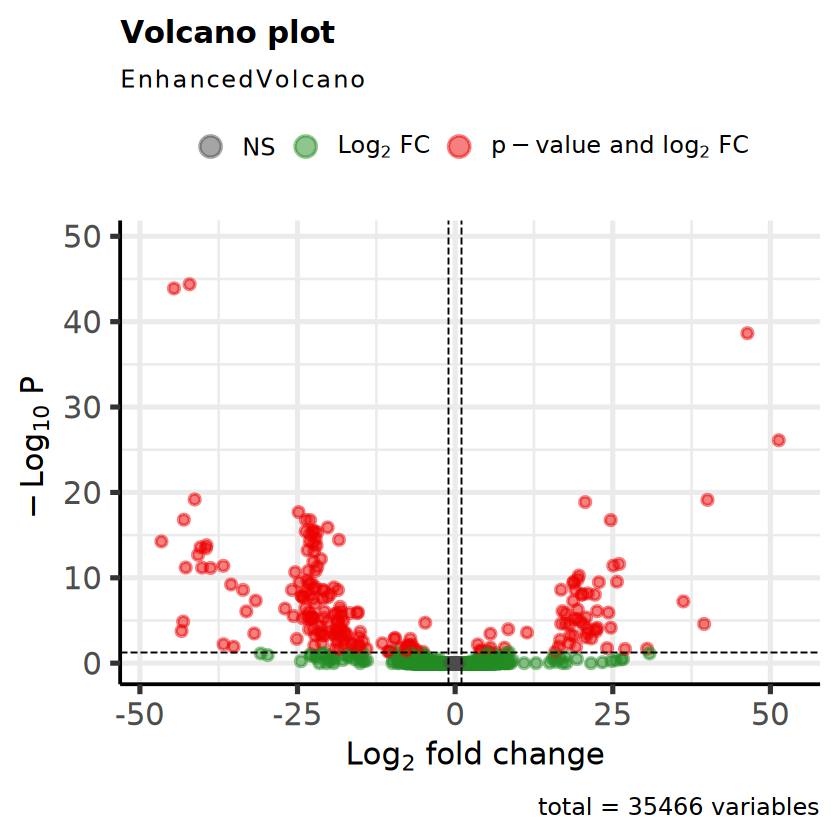

In [53]:
res.hh.ch <- results(dds, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.hypoxic'), # CH is the "control"
                    lfcThreshold = 1, alpha = 0.05)

summary(res.hh.ch)

EnhancedVolcano(res.hh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hh.ch <- merge(res.hh.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hh.ch)[1] <- 'Gene'

head(res.hh.ch)

In [54]:
write.csv(res.hh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hh_ch.csv', row.names = FALSE)

**WW vs. CW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 41, 0.12%
LFC < -1.00 (down) : 38, 0.11%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842 -1.12440600    0.7904298 -0.1573903 0.8749372 1   
2 LOC111126949 539.2853993 -0.30943468    0.3588728  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 -0.04127593    0.2458129  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032 -0.51857950    1.0933018  0.0000000 1.0000000 1   
5 LOC111120752 429.0263780  0.14915911    0.2878863  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474  0.89630131    8.1477666  0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

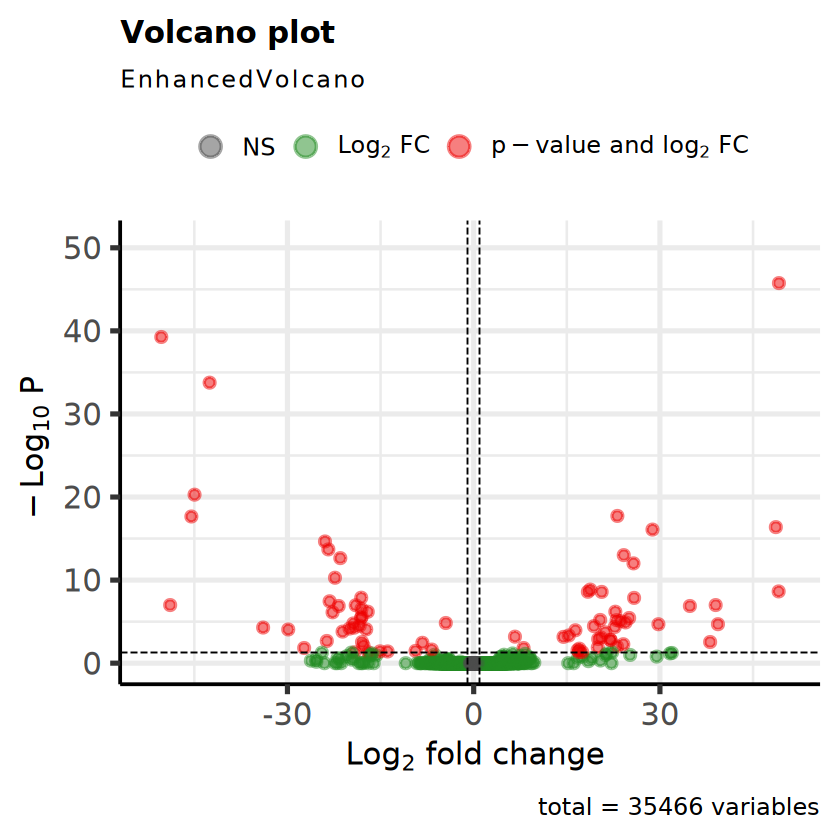

In [55]:
res.ww.cw <- results(dds, contrast= c('complete_trtmt', 'warm.warm', 'control.warm'), # CW is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.ww.cw)

EnhancedVolcano(res.ww.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ww.cw <- merge(res.ww.cw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ww.cw)[1] <- 'Gene'

head(res.ww.cw)

In [56]:
write.csv(res.ww.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/ww_cw.csv', row.names = FALSE)

**BB vs. CB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 34, 0.096%
LFC < -1.00 (down) : 94, 0.27%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat     pvalue    padj
1 LOC111116054   9.0629842  1.82277018    0.7672127 1.072415 0.2835338 1   
2 LOC111126949 539.2853993 -0.04053686    0.3585555 0.000000 1.0000000 1   
3 LOC111110729 114.0070007  0.43451450    0.2503955 0.000000 1.0000000 1   
4 LOC111112434   6.9517032 -0.44445640    1.0472693 0.000000 1.0000000 1   
5 LOC111120752 429.0263780  0.04828649    0.2883833 0.000000 1.0000000 1   
6 LOC111128944   0.1088474  0.06589180    8.1585353 0.000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

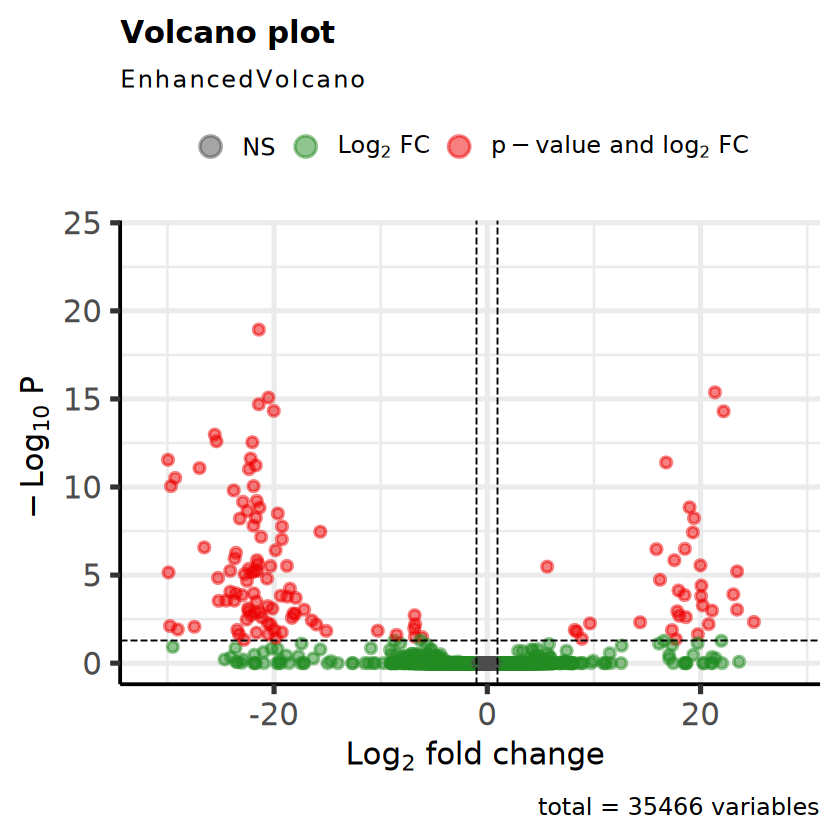

In [57]:
res.cb.bb <- results(dds, name = 'complete_trtmt_control.both_vs_both.both', # BB is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cb.bb)

EnhancedVolcano(res.cb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.bb <- merge(res.cb.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.bb)[1] <- 'Gene'

head(res.cb.bb)

In [58]:
write.csv(res.cb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cb_bb.csv', row.names = FALSE)

#### 5B. Semi-matched priming: in context of later *single* stress
- CH vs. BH
- CW vs. BW

**CH vs. BH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 81, 0.23%
LFC < -1.00 (down) : 145, 0.41%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat      pvalue    padj
1 LOC111116054   9.0629842  1.45062582    0.7711148 0.5843823 0.5589631 1   
2 LOC111126949 539.2853993 -0.15658064    0.3589383 0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 -0.02264502    0.2500169 0.0000000 1.0000000 1   
4 LOC111112434   6.9517032  2.67126709    1.0584427 1.5789868 0.1143391 1   
5 LOC111120752 429.0263780  0.82322229    0.2878580 0.0000000 1.0000000 1   
6 LOC111128944   0.1088474 -0.65119290    8.1601844 0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

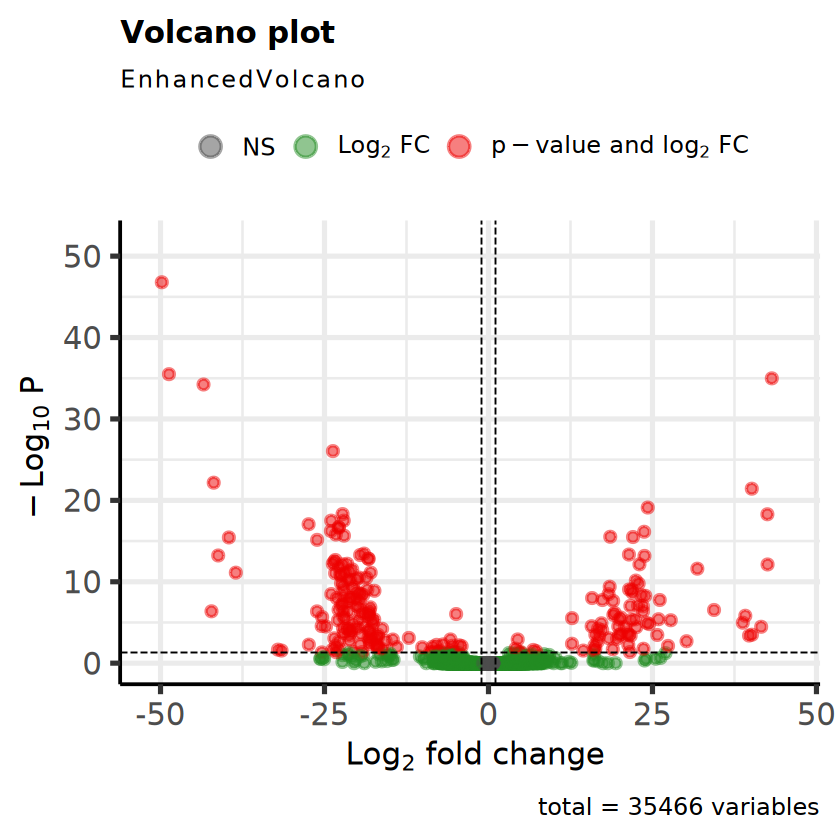

In [59]:
res.bh.ch <- results(dds, contrast= c('complete_trtmt', 'both.hypoxic', 'control.hypoxic'), # CH is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bh.ch)

EnhancedVolcano(res.bh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bh.ch <- merge(res.bh.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bh.ch)[1] <- 'Gene'

head(res.bh.ch)

In [60]:
write.csv(res.bh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bh_ch.csv', row.names = FALSE)

**CW vs. BW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 49, 0.14%
LFC < -1.00 (down) : 102, 0.29%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.83270732    0.7838380 0    1      1      1.875059
2 LOC111126949 539.2853993  0.01500577    0.3587173 0    1      1    829.713451
3 LOC111110729 114.0070007 -0.08583363    0.2462407 0    1      1     60.001877
4 LOC111112434   6.9517032  0.73796888    1.0667434 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.37805206    0.2885469 0    1      1    337.510556
6 LOC111128944   0.1088474 -0.99853591    8.1608438 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

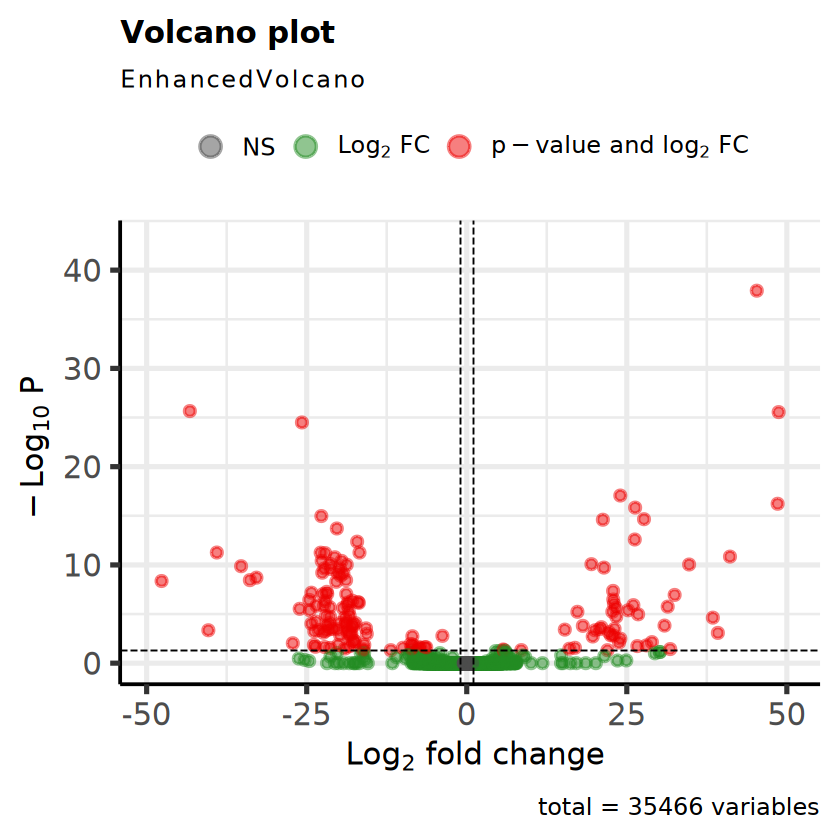

In [61]:
res.bw.cw <- results(dds, contrast= c('complete_trtmt', 'both.warm', 'control.warm'), # CW is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bw.cw)

EnhancedVolcano(res.bw.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bw.cw <- merge(res.bw.cw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bw.cw)[1] <- 'Gene'

head(res.bw.cw)

In [71]:
write.csv(res.bw.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bw_cw.csv', row.names = FALSE)

#### 5C. Semi-matched priming: in context of later *multiple* stress
- CB vs. WB
- CB vs. HB

**CB vs. WB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 113, 0.32%
LFC < -1.00 (down) : 47, 0.13%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat         pvalue    padj
1 LOC111116054   9.0629842 -1.1891397     0.7548752 -0.250557543 0.8021562 1   
2 LOC111126949 539.2853993  0.2093021     0.3585314  0.000000000 1.0000000 1   
3 LOC111110729 114.0070007  0.3816613     0.2473645  0.000000000 1.0000000 1   
4 LOC111112434   6.9517032 -0.1471936     1.0576490  0.000000000 1.0000000 1   
5 LOC111120752 429.0263780  0.1536491     0.2882947  0.000000000 1.0000000 1   
6 LOC111128944   0.1088474  1.0092709     8.1608438  0.001136024 0.9990936 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

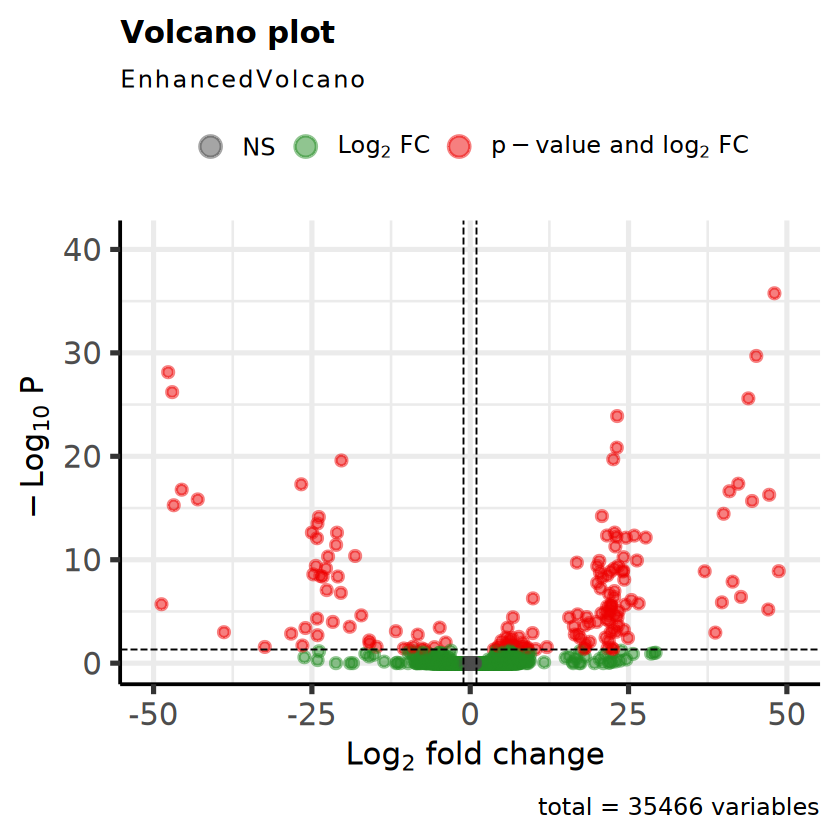

In [72]:
res.wb.cb <- results(dds, contrast = c('complete_trtmt', 'warm.both', 'control.both'), # CB is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.wb.cb)

EnhancedVolcano(res.wb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.cb <- merge(res.wb.cb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.cb)[1] <- 'Gene'

head(res.wb.cb)

In [73]:
write.csv(res.wb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wb_cb.csv', row.names = FALSE)

**CB vs. HB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 64, 0.18%
LFC < -1.00 (down) : 48, 0.14%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842 -0.6218277     0.7469713  0.0000000 1.0000000 1   
2 LOC111126949 539.2853993  0.1138534     0.3586448  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 -0.3059673     0.2509714  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032 -1.7050150     1.1135407 -0.6331291 0.5266494 1   
5 LOC111120752 429.0263780  0.3198692     0.2882393  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474  0.0000000     8.1608438  0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

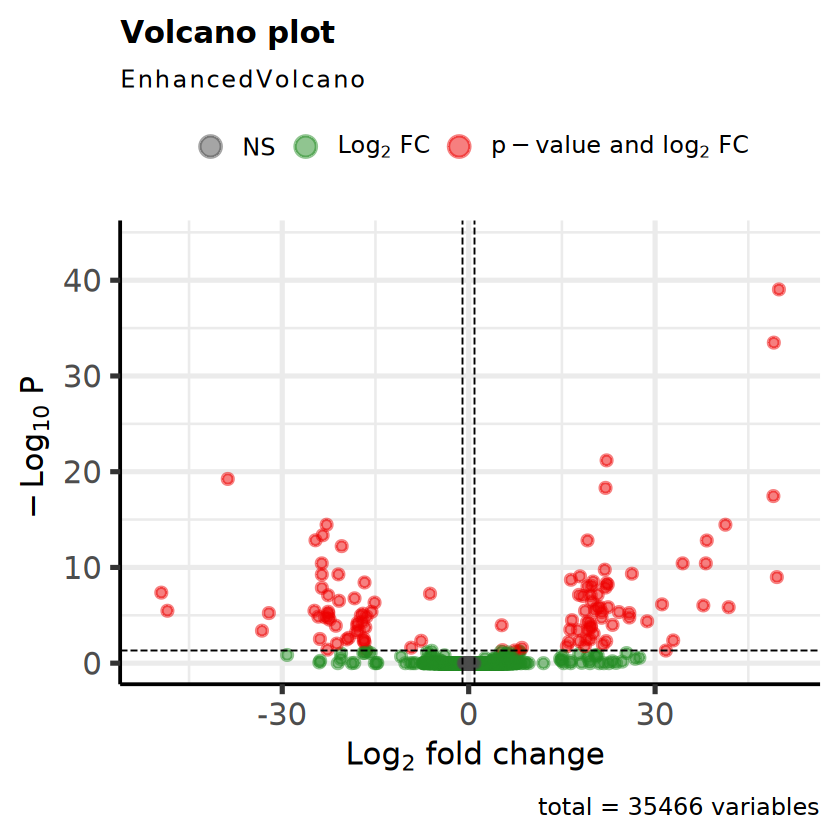

In [74]:
res.hb.cb <- results(dds, contrast = c('complete_trtmt', 'hypoxic.both', 'control.both'), # CB is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.hb.cb)

EnhancedVolcano(res.hb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.cb <- merge(res.hb.cb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.cb)[1] <- 'Gene'

head(res.hb.cb)

In [75]:
write.csv(res.hb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hb_cb.csv', row.names = FALSE)

### 6. Effect of initial exposure on subsequent response to stress
Oysters all experience the same early stressor, but either return to that stressor or experience control conditions
- HC vs. HH
- WC vs. WW
- BB vs. BC

**HC vs. HH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 156, 0.44%
LFC < -1.00 (down) : 75, 0.21%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 0.4917540      0.8065191 0    1      1      1.875059
2 LOC111126949 539.2853993 0.5165913      0.3770194 0    1      1    829.713451
3 LOC111110729 114.0070007 0.1604710      0.2617483 0    1      1     60.001877
4 LOC111112434   6.9517032 0.8389671      1.1148703 0    1      1     10.312823
5 LOC111120752 429.0263780 0.2252259      0.3017569 0    1      1    337.510556
6 LOC111128944   0.1088474 0.0000000      8.5591341 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

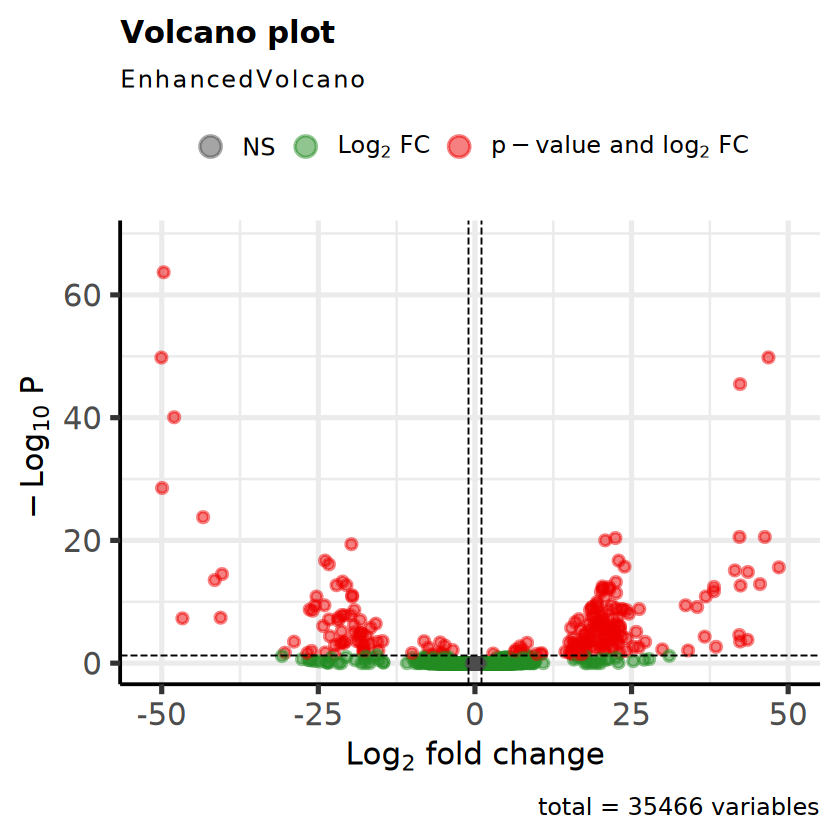

In [76]:
res.hc.hh <- results(dds, contrast = c('complete_trtmt', 'hypoxic.control', 'hypoxic.hypoxic'), # HH is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.hc.hh)

EnhancedVolcano(res.hc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hc.hh <- merge(res.hc.hh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hc.hh)[1] <- 'Gene'

head(res.hc.hh)

In [77]:
write.csv(res.hc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hc_hh.csv', row.names = FALSE)

**WC vs. WW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 49, 0.14%
LFC < -1.00 (down) : 54, 0.15%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842  1.65858747    0.7822237  0.8419426 0.3998201 1   
2 LOC111126949 539.2853993 -0.06865630    0.3591030  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 -0.36007568    0.2471938  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032  0.76238549    1.0867994  0.0000000 1.0000000 1   
5 LOC111120752 429.0263780 -0.03685597    0.2877336  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474 -1.92007819    8.1477666 -0.1129240 0.9100908 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

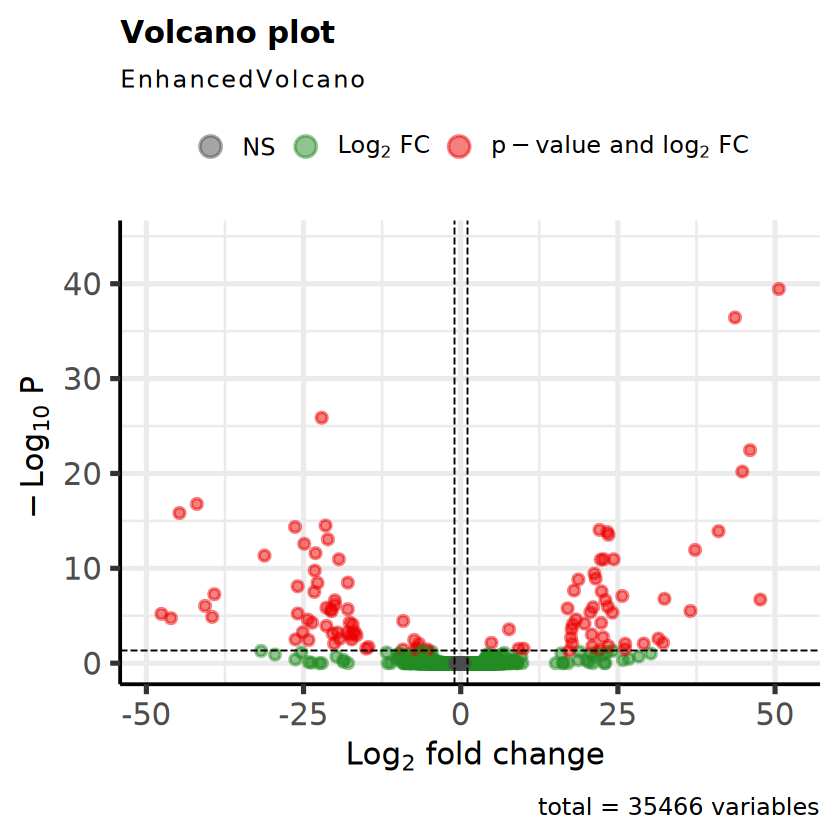

In [78]:
res.wc.ww <- results(dds, contrast = c('complete_trtmt', 'warm.control', 'warm.warm'), alpha = 0.05, lfcThreshold = 1)

summary(res.wc.ww)

EnhancedVolcano(res.wc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.ww <- merge(res.wc.ww, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.ww)[1] <- 'Gene'

head(res.wc.ww)

In [79]:
write.csv(res.wc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wc_ww.csv', row.names = FALSE)

**BC vs. BB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 28, 0.079%
LFC < -1.00 (down) : 148, 0.42%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.7947621     0.8138633 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.3133418     0.3761639 0    1      1    829.713451
3 LOC111110729 114.0070007  0.3370872     0.2623182 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.7465880     1.1025184 0    1      1     10.312823
5 LOC111120752 429.0263780  0.2488804     0.3020847 0    1      1    337.510556
6 LOC111128944   0.1088474 -0.0764369     8.5568813 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

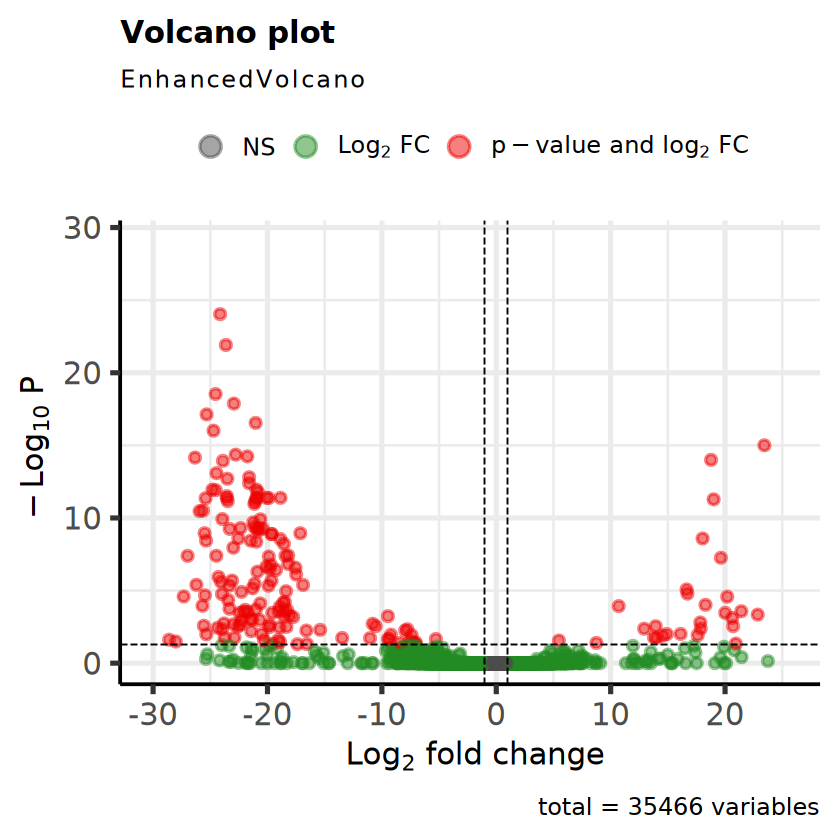

In [81]:
res.bc.bb <- results(dds, name = 'complete_trtmt_both.control_vs_both.both', # BB is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bc.bb)

EnhancedVolcano(res.bc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.bb <- merge(res.bc.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.bb)[1] <- 'Gene'

head(res.bc.bb)

In [82]:
write.csv(res.bc.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bc_bb.csv', row.names = FALSE)

### 7. Effect of initial single/multiple stress on response in ...
Is it better to be primed with a single stressor or multiple stressor, depending on the context of the future enviornment (single/multiple stressor)?

#### 7A. ...later *single* stress
Oyster is primed with either multiple or a single stressors, and then experiences only a sinlge stressor later
- BH vs. HH
- BW vs. WW

**BH vs. HH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 140, 0.4%
LFC < -1.00 (down) : 106, 0.3%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat      pvalue    padj
1 LOC111116054   9.0629842 1.1262010      0.8021151 0.1573352 0.8749807 1   
2 LOC111126949 539.2853993 0.6838762      0.3771356 0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 0.1784888      0.2630822 0.0000000 1.0000000 1   
4 LOC111112434   6.9517032 2.3591979      1.1042464 1.2308828 0.2183667 1   
5 LOC111120752 429.0263780 0.6146368      0.3017083 0.0000000 1.0000000 1   
6 LOC111128944   0.1088474 0.0000000      8.5591341 0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

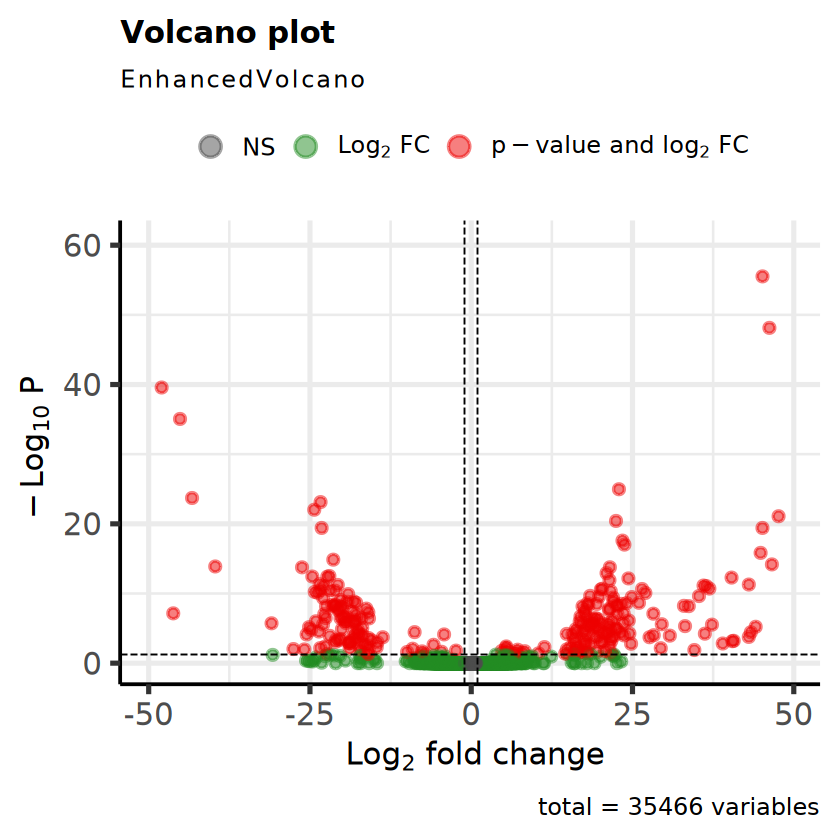

In [83]:
res.hh.bh <- results(dds, contrast= c('complete_trtmt', 'both.hypoxic', 'hypoxic.hypoxic'), # HH is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.hh.bh)

EnhancedVolcano(res.hh.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hh.bh <- merge(res.hh.bh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hh.bh)[1] <- 'Gene'

head(res.hh.bh)

In [85]:
write.csv(res.hh.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bh_hh.csv', row.names = FALSE)

**BW vs. WW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 44, 0.12%
LFC < -1.00 (down) : 110, 0.31%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842  0.2916987     0.8084477  0.0000000 1.0000000 1   
2 LOC111126949 539.2853993  0.3244404     0.3588425  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 -0.0445577     0.2459860  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032  1.2565484     1.0783327  0.2379121 0.8119493 1   
5 LOC111120752 429.0263780 -0.5272112     0.2882923  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474 -1.8948372     8.1477666 -0.1098261 0.9125473 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

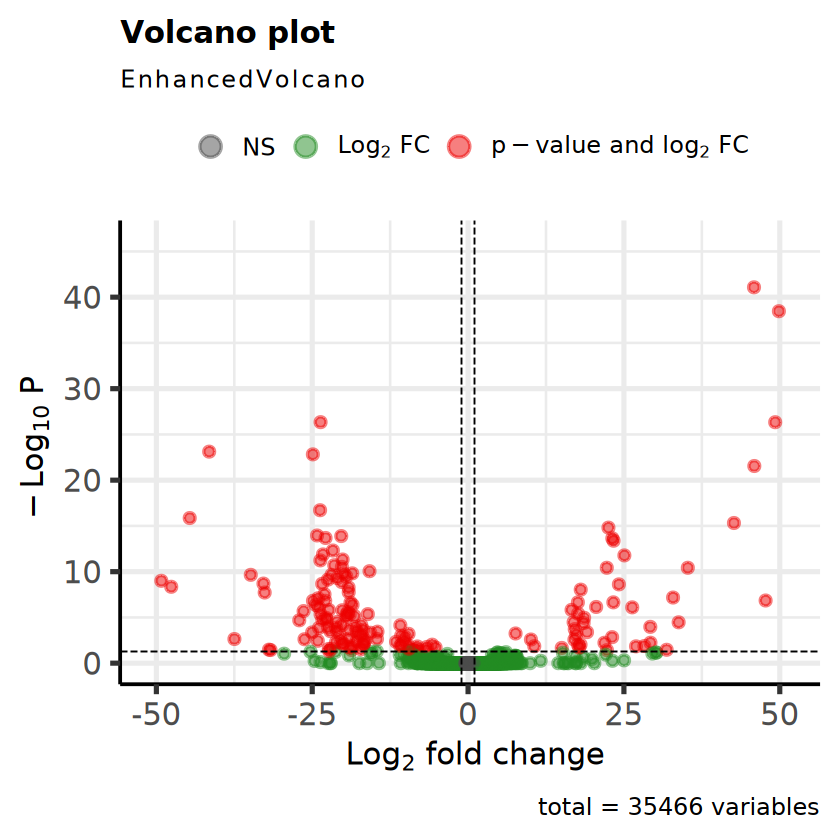

In [86]:
res.bw.ww <- results(dds, contrast= c('complete_trtmt', 'both.warm', 'warm.warm'), # WW is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bw.ww)

EnhancedVolcano(res.bw.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bw.ww <- merge(res.bw.ww, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bw.ww)[1] <- 'Gene'

head(res.bw.ww)

In [87]:
write.csv(res.bw.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bw_ww.csv', row.names = FALSE)

#### 7B. ...later *multiple* stressors
Oyster is primed with either multiple or a single stressors, and then experiences multiple stressors later
- HB vs. BB
- WB vs. BB

**HB vs. BB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 39, 0.11%
LFC < -1.00 (down) : 72, 0.2%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842  1.20094250    0.7759998  0.2589466 0.7956765 1   
2 LOC111126949 539.2853993  0.07331654    0.3585912  0.0000000 1.0000000 1   
3 LOC111110729 114.0070007  0.12854721    0.2527609  0.0000000 1.0000000 1   
4 LOC111112434   6.9517032 -2.14947136    1.1070826 -1.0382887 0.2991357 1   
5 LOC111120752 429.0263780  0.36815574    0.2882274  0.0000000 1.0000000 1   
6 LOC111128944   0.1088474  0.22060492    8.1585353  0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

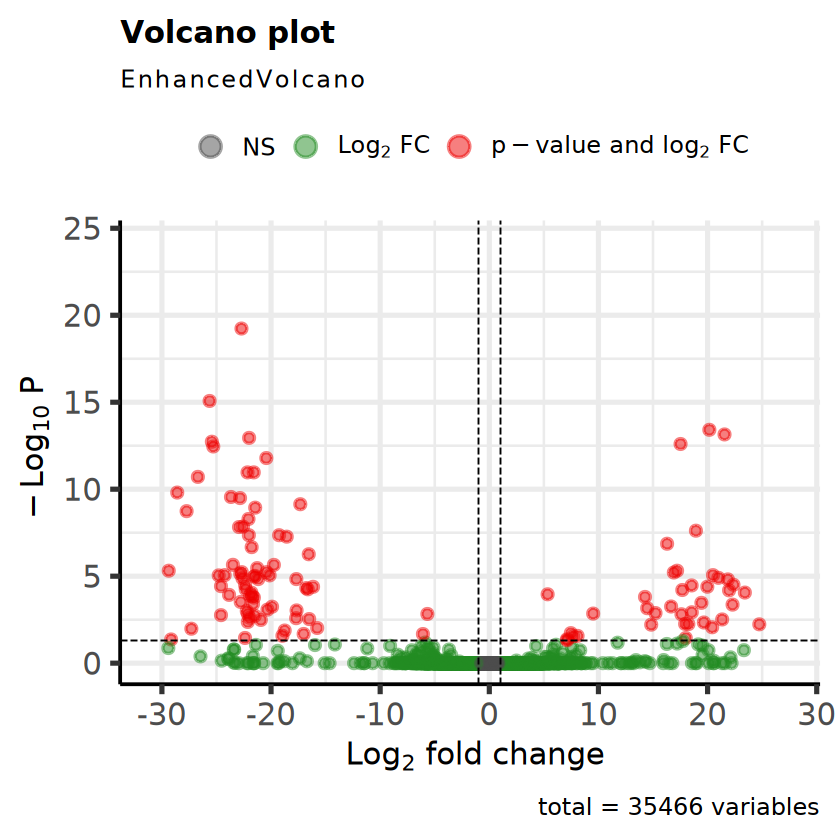

In [88]:
res.hb.bb <- results(dds, 
                       name = 'complete_trtmt_hypoxic.both_vs_both.both', # BB is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.hb.bb)

EnhancedVolcano(res.hb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.bb <- merge(res.hb.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.bb)[1] <- 'Gene'

head(res.hb.bb)

In [89]:
write.csv(res.hb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hb_bb.csv', row.names = FALSE)

**WB vs. BB**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 33, 0.093%
LFC < -1.00 (down) : 48, 0.14%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    padj
1 LOC111116054   9.0629842  0.6336305     0.7836110 0.000000000 1.0000000 1   
2 LOC111126949 539.2853993  0.1687652     0.3584778 0.000000000 1.0000000 1   
3 LOC111110729 114.0070007  0.8161758     0.2491799 0.000000000 1.0000000 1   
4 LOC111112434   6.9517032 -0.5916500     1.0508477 0.000000000 1.0000000 1   
5 LOC111120752 429.0263780  0.2019356     0.2882827 0.000000000 1.0000000 1   
6 LOC111128944   0.1088474  1.0751627     8.1585353 0.009212771 0.9926494 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

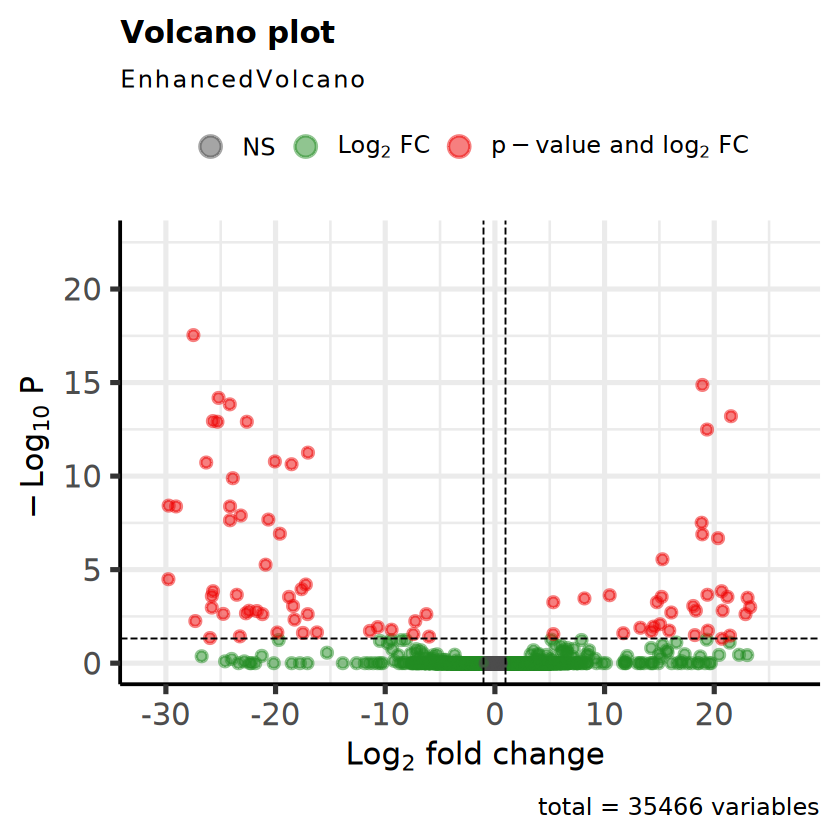

In [90]:
res.wb.bb <- results(dds, 
                       name = 'complete_trtmt_warm.both_vs_both.both', # BB is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.wb.bb)

EnhancedVolcano(res.wb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.bb <- merge(res.wb.bb, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.bb)[1] <- 'Gene'

head(res.wb.bb)

In [91]:
write.csv(res.wb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wb_bb.csv', row.names = FALSE)

### 8. Shared/Unique responses among stressors with ...

#### 8A. ...different *early* stressors
>can compare these with the phase 1 vs. phase 1 DEGs to see if there are similarities
- WC vs. HC: single early stress
- BC vs. HC: mulitple vs. single
- BC vs. WC: multiple vs. single

**WC vs. HC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 77, 0.22%
LFC < -1.00 (down) : 52, 0.15%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.49811703    0.7542736 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.03319808    0.3591352 0    1      1    829.713451
3 LOC111110729 114.0070007  0.09642556    0.2489557 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.55140150    1.0582242 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.08959955    0.2876970 0    1      1    337.510556
6 LOC111128944   0.1088474  0.00000000    8.1608438 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

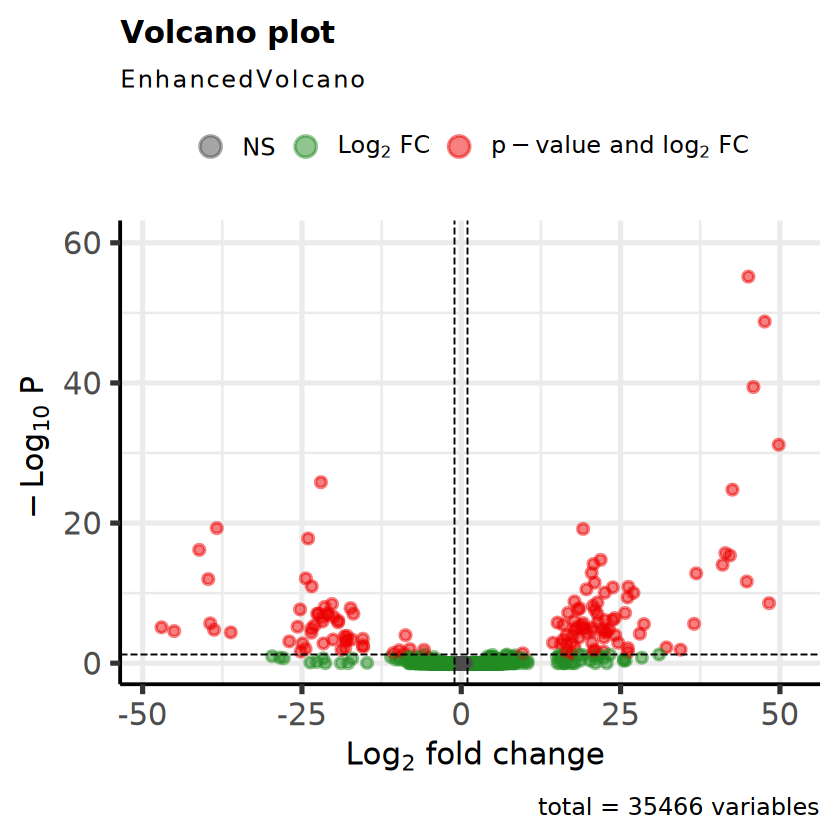

In [92]:
res.wc.hc <- results(dds, contrast=c('complete_trtmt', 'warm.control', 'hypoxic.control'), # HC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.wc.hc)

EnhancedVolcano(res.wc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.hc <- merge(res.wc.hc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.hc)[1] <- 'Gene'

head(res.wc.hc)

In [93]:
write.csv(res.wc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wc_hc.csv', row.names = FALSE)

**BC vs. HC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 71, 0.2%
LFC < -1.00 (down) : 132, 0.37%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.01015806    0.7968678 0    1      1      1.875059
2 LOC111126949 539.2853993  0.16655186    0.3764311 0    1      1    829.713451
3 LOC111110729 114.0070007  0.04459472    0.2608345 0    1      1     60.001877
4 LOC111112434   6.9517032 -0.43528054    1.1059480 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.14205658    0.3016967 0    1      1    337.510556
6 LOC111128944   0.1088474  0.00000000    8.5591341 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

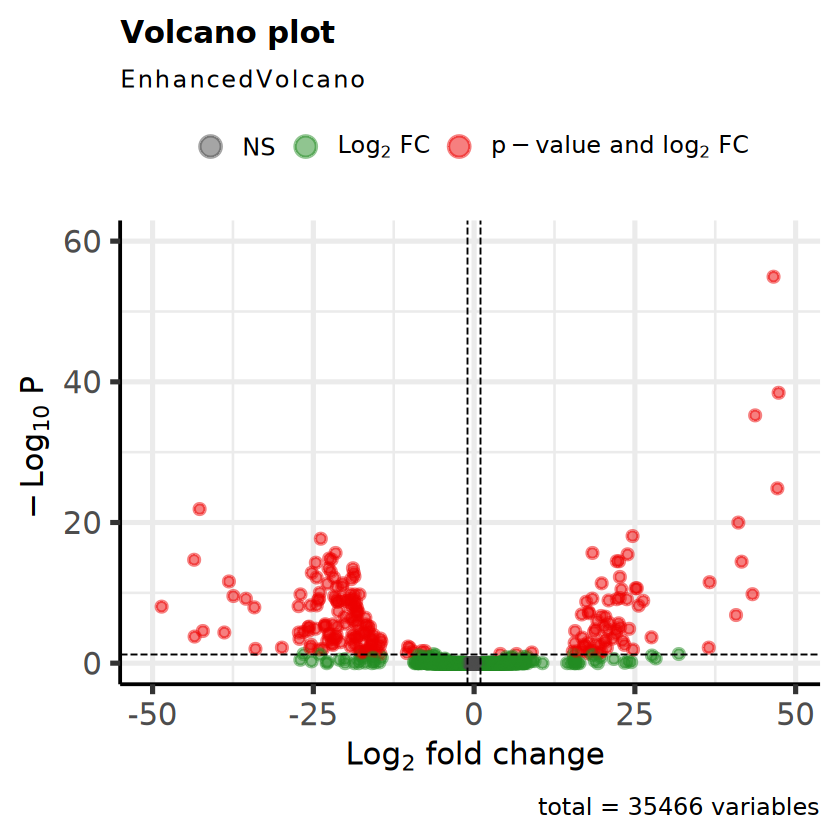

In [94]:
res.bc.hc <- results(dds, contrast=c('complete_trtmt', 'both.control', 'hypoxic.control'), # HC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bc.hc)

EnhancedVolcano(res.bc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.hc <- merge(res.bc.hc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.hc)[1] <- 'Gene'

head(res.bc.hc)

In [95]:
write.csv(res.bc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bc_hc.csv', row.names = FALSE)

**BC vs. WC**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 45, 0.13%
LFC < -1.00 (down) : 141, 0.4%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 -0.50827509    0.7911085 0    1      1      1.875059
2 LOC111126949 539.2853993  0.19974995    0.3765006 0    1      1    829.713451
3 LOC111110729 114.0070007 -0.05183085    0.2607041 0    1      1     60.001877
4 LOC111112434   6.9517032  0.11612096    1.1159657 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.05245703    0.3018293 0    1      1    337.510556
6 LOC111128944   0.1088474  0.00000000    8.5591341 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

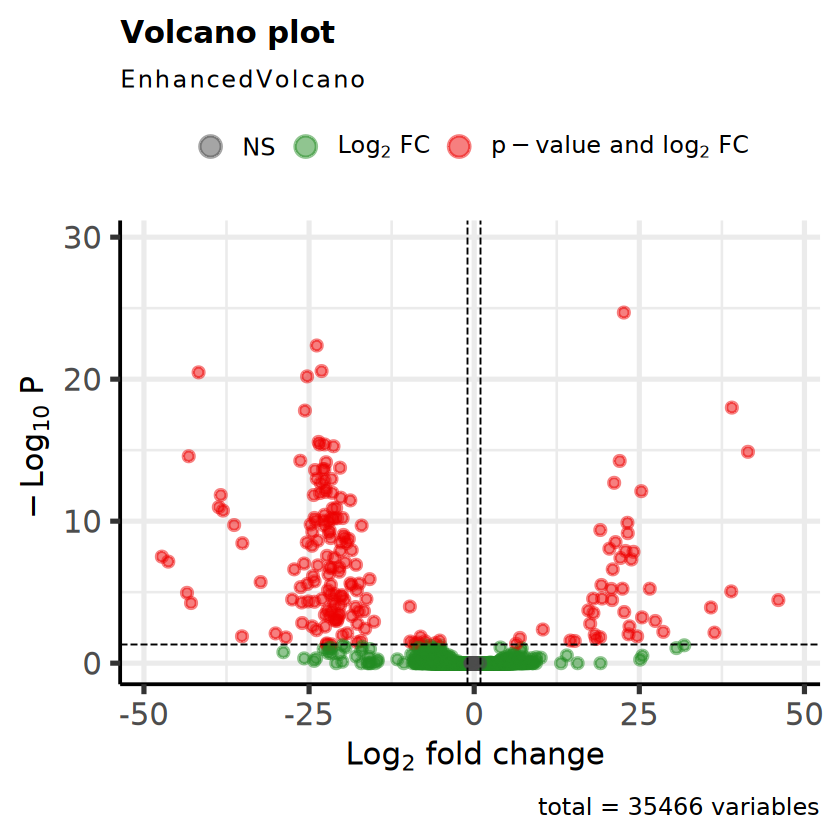

In [96]:
res.bc.wc <- results(dds, contrast=c('complete_trtmt', 'both.control', 'warm.control'), # WC is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.bc.wc)

EnhancedVolcano(res.bc.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.wc <- merge(res.bc.wc, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.wc)[1] <- 'Gene'

head(res.bc.wc)

In [97]:
write.csv(res.bc.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/bc_wc.csv', row.names = FALSE)

#### 8B. ...different *late* stressors
- CW vs. CH: single early stress
- CB vs. CH: mulitple vs. single
- CB vs. CW: multiple vs. single

**CW vs. CH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 88, 0.25%
LFC < -1.00 (down) : 45, 0.13%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842 0.78011442     0.7781145 0    1      1      1.875059
2 LOC111126949 539.2853993 0.02102736     0.3586586 0    1      1    829.713451
3 LOC111110729 114.0070007 0.45711436     0.2471024 0    1      1     60.001877
4 LOC111112434   6.9517032 0.35582880     1.0864213 0    1      1     10.312823
5 LOC111120752 429.0263780 0.23190873     0.2882005 0    1      1    337.510556
6 LOC111128944   0.1088474 0.18742890     8.1601844 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

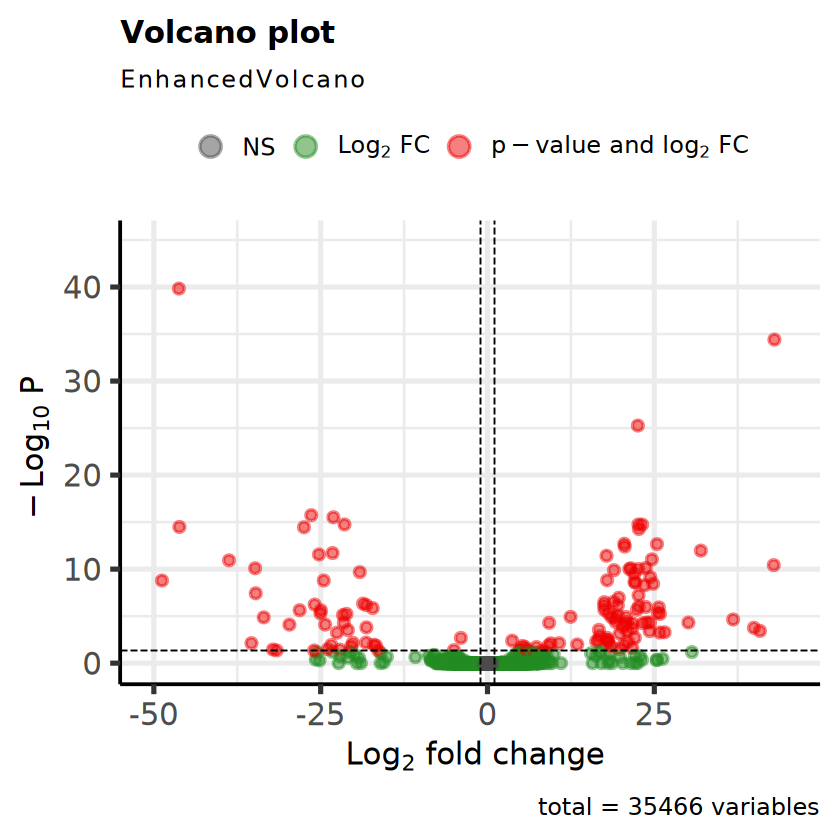

In [98]:
res.cw.ch <- results(dds, contrast=c('complete_trtmt', 'control.warm', 'control.hypoxic'), # CH is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cw.ch)

EnhancedVolcano(res.cw.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.ch <- merge(res.cw.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.ch)[1] <- 'Gene'

head(res.cw.ch)

In [99]:
write.csv(res.cw.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cw_ch.csv', row.names = FALSE)

**CB vs. CH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 79, 0.22%
LFC < -1.00 (down) : 81, 0.23%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    padj
1 LOC111116054   9.0629842  1.83402884    0.7647667 1.09056636 0.2754637 1   
2 LOC111126949 539.2853993  0.11549131    0.3585894 0.00000000 1.0000000 1   
3 LOC111110729 114.0070007  0.10135919    0.2483610 0.00000000 1.0000000 1   
4 LOC111112434   6.9517032  1.01788735    1.0726805 0.01667537 0.9866956 1   
5 LOC111120752 429.0263780  0.09116093    0.2883275 0.00000000 1.0000000 1   
6 LOC111128944   0.1088474 -0.80210001    8.1601844 0.00000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

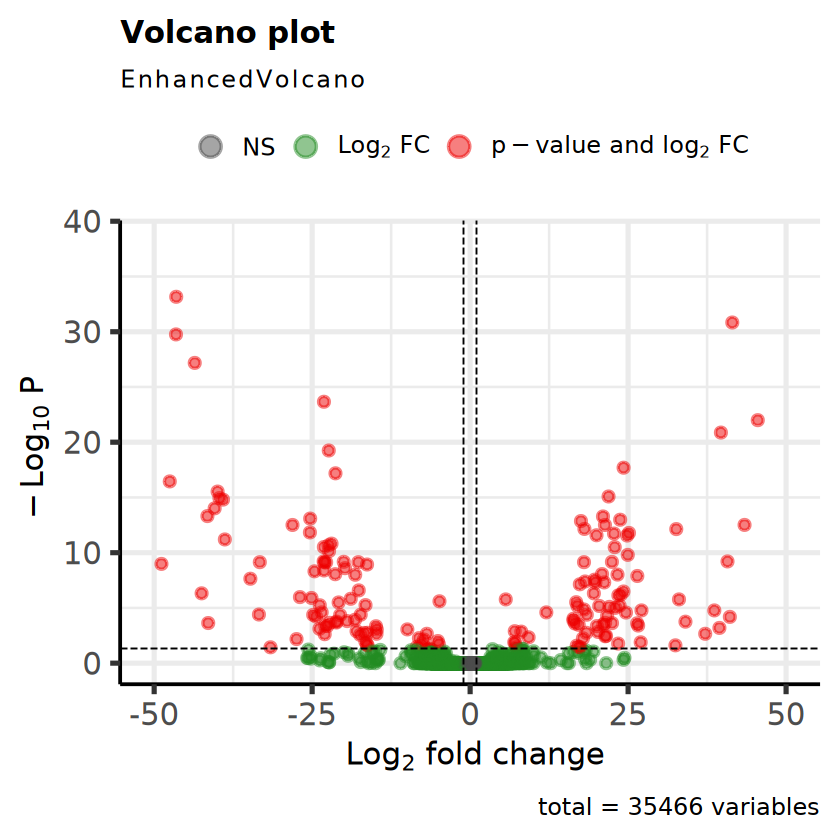

In [100]:
res.cb.ch <- results(dds, contrast=c('complete_trtmt', 'control.both', 'control.hypoxic'), # CH is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cb.ch)

EnhancedVolcano(res.cb.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.ch <- merge(res.cb.ch, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.ch)[1] <- 'Gene'

head(res.cb.ch)

In [101]:
write.csv(res.cb.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cb_ch.csv', row.names = FALSE)

**CB vs. CW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 52, 0.15%
LFC < -1.00 (down) : 89, 0.25%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat      pvalue    padj
1 LOC111116054   9.0629842  1.05391442    0.7516646 0.0717267 0.9428194 1   
2 LOC111126949 539.2853993  0.09446395    0.3586783 0.0000000 1.0000000 1   
3 LOC111110729 114.0070007 -0.35575518    0.2473316 0.0000000 1.0000000 1   
4 LOC111112434   6.9517032  0.66205855    1.0680737 0.0000000 1.0000000 1   
5 LOC111120752 429.0263780 -0.14074780    0.2882683 0.0000000 1.0000000 1   
6 LOC111128944   0.1088474 -0.98952891    8.1608438 0.0000000 1.0000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

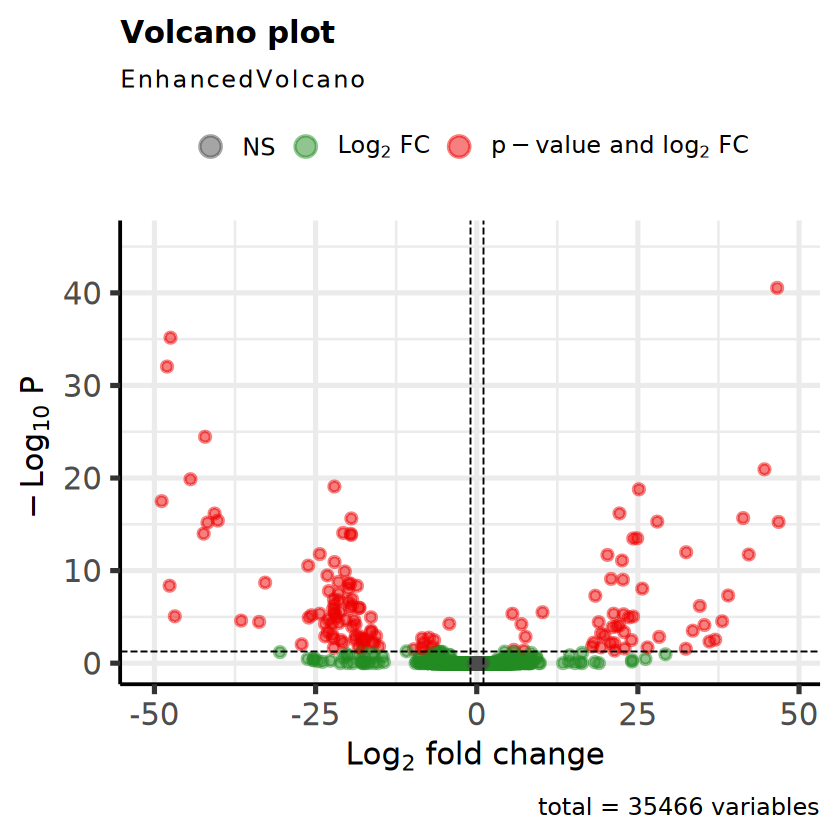

In [102]:
res.cb.cw <- results(dds, contrast=c('complete_trtmt', 'control.both', 'control.warm'), # CW is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.cb.cw)

EnhancedVolcano(res.cb.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.cw <- merge(res.cb.cw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.cw)[1] <- 'Gene'

head(res.cb.cw)

In [103]:
write.csv(res.cb.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/cb_cw.csv', row.names = FALSE)

### 9. Effect of the order of stressors
Does the order of when stress is experienced matter? Maybe one stressor is an informative cue for a later environmnet?
- WH vs. HW
- WB vs. BW
- HB vs. BH

**WH vs. HW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 73, 0.21%
LFC < -1.00 (down) : 50, 0.14%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat pvalue padj B1_B1_O01 
1 LOC111116054   9.0629842  0.25198069    0.7929407 0    1      1      1.875059
2 LOC111126949 539.2853993 -0.73132654    0.3587388 0    1      1    829.713451
3 LOC111110729 114.0070007 -0.03441662    0.2496059 0    1      1     60.001877
4 LOC111112434   6.9517032  0.53549185    1.0659728 0    1      1     10.312823
5 LOC111120752 429.0263780 -0.09935364    0.2880815 0    1      1    337.510556
6 LOC111128944   0.1088474  0.00000000    8.1608438 0    1      1      0.000000
  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46  W5_W2_G22 
1   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592   7.359253
2 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160 650.373981
3  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128 111.308701
4   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777   3.679626
5 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176 402.919100
6   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000   0.000000
  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   5.277065   2.300668  21.05700   1.075999   0.0000 
2 428.497663 480.839693 469.90350 302.355713 636.4963 
3 121.372491 144.942108 119.69240 136.651870 226.3334 
4   0.000000   2.300668  17.73221   8.607992   0.0000 
5 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.00000   0.000000   0.0000

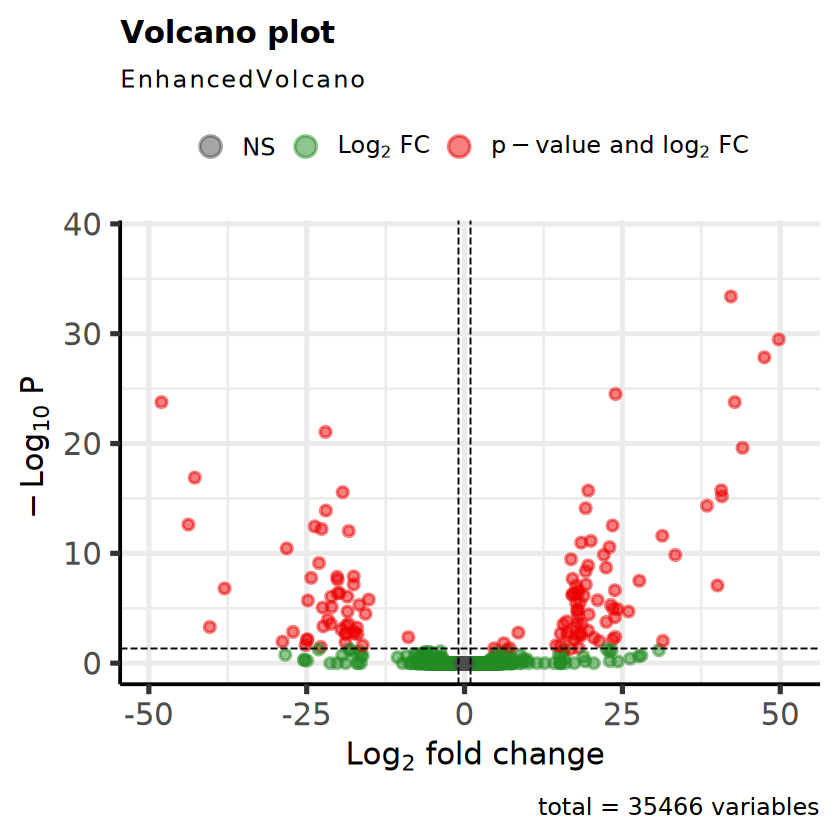

In [104]:
res.wh.hw <- results(dds, contrast=c('complete_trtmt', 'warm.hypoxic', 'hypoxic.warm'), # HW is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.wh.hw)

EnhancedVolcano(res.wh.hw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wh.hw <- merge(res.wh.hw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wh.hw)[1] <- 'Gene'

head(res.wh.hw)

In [105]:
write.csv(res.wh.hw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wh_hw.csv', row.names = FALSE)

**WB vs. BW**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 130, 0.37%
LFC < -1.00 (down) : 47, 0.13%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue   padj
1 LOC111116054   9.0629842  0.6974821     0.7869174 0.000000000 1.000000 1   
2 LOC111126949 539.2853993  0.2887603     0.3585704 0.000000000 1.000000 1   
3 LOC111110729 114.0070007  0.1117398     0.2462737 0.000000000 1.000000 1   
4 LOC111112434   6.9517032 -0.2231039     1.0563057 0.000000000 1.000000 1   
5 LOC111120752 429.0263780  0.3909534     0.2885732 0.000000000 1.000000 1   
6 LOC111128944   0.1088474  1.0182779     8.1608438 0.002239708 0.998213 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

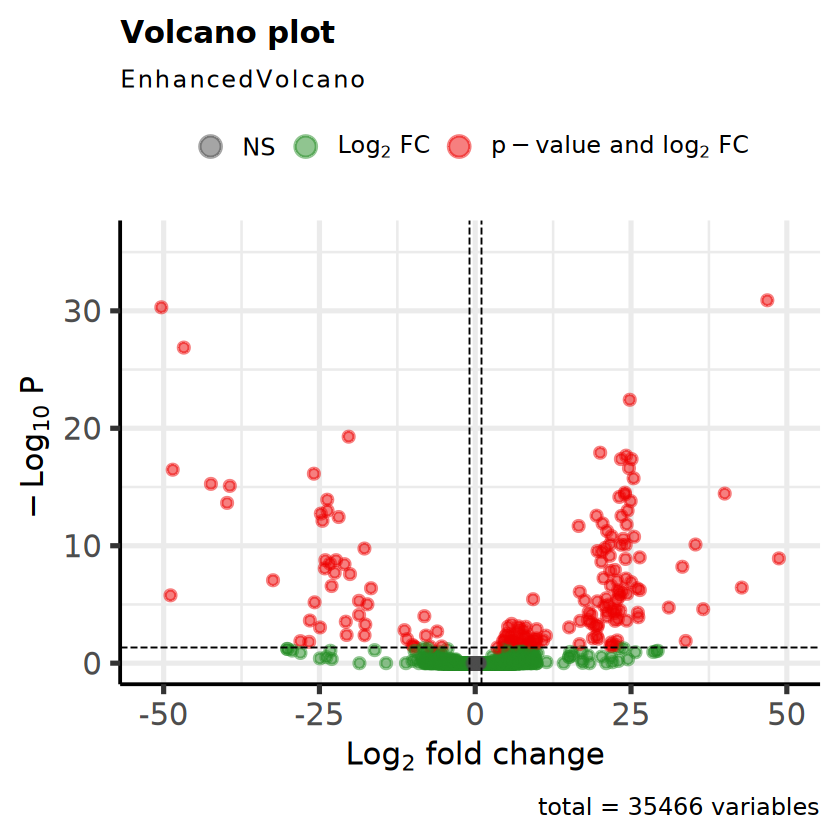

In [106]:
res.wb.bw <- results(dds, contrast=c('complete_trtmt', 'warm.both', 'both.warm'), # BW is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.wb.bw)

EnhancedVolcano(res.wb.bw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.bw <- merge(res.wb.bw, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.bw)[1] <- 'Gene'

head(res.wb.bw)

In [107]:
write.csv(res.wb.bw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/wb_bw.csv', row.names = FALSE)

**HB vs. BH**


out of 35396 with nonzero total read count
adjusted p-value < 0.05
LFC > 1.00 (up)    : 185, 0.52%
LFC < -1.00 (down) : 69, 0.19%
outliers [1]       : 291, 0.82%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Gene         baseMean    log2FoldChange lfcSE     stat      pvalue     padj
1 LOC111116054   9.0629842 -0.2384247     0.7534693  0.000000 1.00000000 1   
2 LOC111126949 539.2853993  0.3859253     0.3589936  0.000000 1.00000000 1   
3 LOC111110729 114.0070007 -0.1819631     0.2526103  0.000000 1.00000000 1   
4 LOC111112434   6.9517032 -3.3583947     1.0998319 -2.144323 0.03200703 1   
5 LOC111120752 429.0263780 -0.4121921     0.2877697  0.000000 1.00000000 1   
6 LOC111128944   0.1088474  0.0000000     8.1608438  0.000000 1.00000000 1   
  B1_B1_O01  B1_W5_O50  B2_B5_O51 ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1   1.875059   5.965799   9.44740 ⋯   4.336105   2.452846  11.19491   2.006592
2 829.713451 474.281013 617.85999 ⋯ 230.897604 544.531781 506.25864 742.439160
3  60.001877  92.469883  59.51862 ⋯ 128.999131  62.138762  87.07151 149.491128
4  10.312823   1.988600   0.00000 ⋯   6.504158   0.000000  13.68267   6.019777
5 337.510556 334.084739 402.45926 ⋯ 421.686235 286.165350 446.55246 346.137176
6   0.000000   0.000000   0.00000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

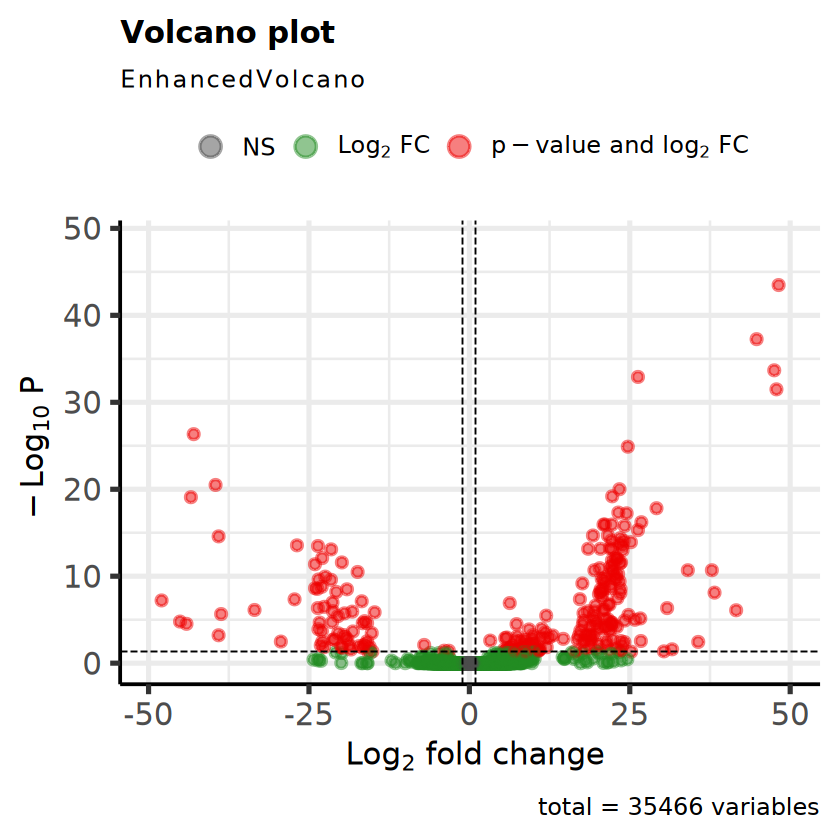

In [108]:
res.hb.bh <- results(dds, contrast=c('complete_trtmt', 'hypoxic.both', 'both.hypoxic'), # BH is the "control"
                      lfcThreshold = 1, alpha = 0.05)

summary(res.hb.bh)

EnhancedVolcano(res.hb.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.bh <- merge(res.hb.bh, counts(dds, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.bh)[1] <- 'Gene'

head(res.hb.bh)

In [109]:
write.csv(res.hb.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_rawLFC/deseq_res/hb_bh.csv', row.names = FALSE)